Make sur you use a python version 3.9, 3.10, 3.11 or 3.12 to used the imbalanced-learn library.

In [1]:
import sys
print(sys.version)

3.12.10 (tags/v3.12.10:0cc8128, Apr  8 2025, 12:21:36) [MSC v.1943 64 bit (AMD64)]


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import precision_recall_curve, auc, average_precision_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

In [3]:
def get_precisions_recalls(actual, preds):
    # Définir les classes pour plus de clarté
    classes = ['Slight', 'Serious', 'Fatal']
    
    # Assurer que les entrées sont des arrays NumPy de chaînes de caractères pour les comparaisons
    actual = np.array(actual, dtype=str)
    preds = np.array(preds, dtype=str)
    
    # --- 1. CALCUL DES MÉTRIQUES ---
    
    # Calcul des Précisions
    precision_slight = np.sum((actual == classes[0]) & (preds == classes[0])) / np.sum(preds == classes[0])
    precision_serious = np.sum((actual == classes[1]) & (preds == classes[1])) / np.sum(preds == classes[1])
    precision_fatal = np.sum((actual == classes[2]) & (preds == classes[2])) / np.sum(preds == classes[2])

    precisions = [precision_slight, precision_serious, precision_fatal]

    # Calcul des Rappels (Recalls)
    # ATTENTION: Votre calcul de rappel initial utilisait des entiers (0, 1) alors que les précisions utilisaient des chaînes ('Slight', 'Serious').
    # Nous corrigeons cela pour utiliser les chaînes pour la cohérence.
    recall_slight = np.sum((actual == classes[0]) & (preds == classes[0])) / np.sum(actual == classes[0])
    recall_serious = np.sum((actual == classes[1]) & (preds == classes[1])) / np.sum(actual == classes[1])
    recall_fatal = np.sum((actual == classes[2]) & (preds == classes[2])) / np.sum(actual == classes[2])
    
    recalls = [recall_slight, recall_serious, recall_fatal]
    
    # --- 2. F1-SCORE COMPUTATION ---
    f1_scores = [
        2 * (precisions[i] * recalls[i]) / (precisions[i] + recalls[i])
        if (precisions[i] + recalls[i]) > 0 else 0
        for i in range(len(classes))
    ]
    
    # --- 2. AFFICHAGE DES GRAPHIQUES ---
    
    plt.figure(figsize=(16, 6))
    x_pos = np.arange(len(classes)) # Positions pour les barres (0, 1, 2)
    
    # Sous-graphe pour la Précision
    plt.subplot(1, 2, 1)
    plt.bar(x_pos, precisions, color=['#1f77b4', '#ff7f0e', '#d62728']) # Couleurs distinctes
    
    plt.xticks(x_pos, classes, fontsize=16)
    plt.yticks(np.arange(0, 1.1, 0.1), fontsize=12)
    plt.ylabel('Précision', fontsize=18)
    
    # Construction du titre avec les trois précisions
    title_precision = (
        f'Précision {classes[0]}: {round(precisions[0], 2)}\n'
        f'Précision {classes[1]}: {round(precisions[1], 2)}\n'
        f'Précision {classes[2]}: {round(precisions[2], 2)}'
    )
    plt.title(title_precision, fontsize=14)
    
    # Sous-graphe pour le Rappel (Recall)
    plt.subplot(1, 2, 2)
    plt.bar(x_pos, recalls, color=['#1f77b4', '#ff7f0e', '#d62728'])
    
    plt.xticks(x_pos, classes, fontsize=16)
    plt.yticks(np.arange(0, 1.1, 0.1), fontsize=12)
    plt.ylabel('Rappel', fontsize=18)
    
    # Construction du titre avec les trois rappels
    title_recall = (
        f'Rappel {classes[0]}: {round(recalls[0], 2)}\n'
        f'Rappel {classes[1]}: {round(recalls[1], 2)}\n'
        f'Rappel {classes[2]}: {round(recalls[2], 2)}'
    )
    plt.title(title_recall, fontsize=14)
    plt.tight_layout()
    plt.show()

     # --- 4. TERMINAL OUTPUT ---
    print("\nF1-scores:")
    for i, cls in enumerate(classes):
        print(f"F1-score {cls}: {f1_scores[i]:.3f}")


In [4]:
def plot_confusion_multi(y_true, y_pred, title="Matrice de Confusion Multi-classe"):
    # On définit l'ordre logique de gravité
    labels = ['Slight', 'Serious', 'Fatal']
    
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    
    fig, ax = plt.subplots(figsize=(7, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(ax=ax, cmap='Reds', values_format='d')
    
    plt.title(title)
    plt.show()

    print(f"--- Rapport détaillé : {title} ---")
    print(classification_report(y_true, y_pred, target_names=labels))

In [5]:
def plot_confusion_binary(y_true, y_pred, title="Matrice de Confusion Binaire"):
    # On force l'ordre pour que 'Fatal' soit en bas à droite (la classe positive)
    if isinstance(y_true[0], (int, np.integer)):
        labels = [0, 1]
        display_labels = ['Non-Fatal', 'Fatal']
    else:
        labels = ['Fatal', 'Non-Fatal']
        display_labels = labels
    
    cm = confusion_matrix(y_true, y_pred)
    
    fig, ax = plt.subplots(figsize=(6, 5))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(ax=ax, cmap='Blues', values_format='d')
    
    plt.title(title)
    plt.show()
    
    # Affichage des métriques clés
    print(f"--- Rapport détaillé : {title} ---")
    print(classification_report(y_true, y_pred))

In [6]:
def plot_multiple_pr_curves(models_dict, X_test, y_test):
    """
    models_dict : dictionnaire { 'Nom du modèle': modele_entrainé }
    """
    plt.figure(figsize=(10, 7))
    
    # Calcul du baseline (taux de Fatal dans le test)
    baseline = y_test.sum() / len(y_test)
    plt.axhline(y=baseline, color='red', linestyle='--', label=f'Baseline (Hasard) : {baseline:.3f}')

    for name, model in models_dict.items():
        # Récupération des probabilités pour la classe 1 (Fatal)
        y_probs = model.predict_proba(X_test)[:, 1]
        
        # Calcul de la courbe et de l'AUC-PR
        precision, recall, _ = precision_recall_curve(y_test, y_probs)
        auc_score = auc(recall, precision)
        avg_prec = average_precision_score(y_test, y_probs) # Autre calcul proche de l'AUC-PR
        
        plt.plot(recall, precision, label=f'{name} (AUC-PR = {auc_score:.3f})')

    plt.xlabel('Rappel (Recall)')
    plt.ylabel('Précision')
    plt.title('Comparaison des courbes Precision-Recall')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

# Read Data

In [11]:
def read_data():
    outcome = "Accident_Severity" 
    #df = pd.read_csv('DATA/RAW/Road Accident Data.csv')
    df=pd.read_csv('../DATA/CLEAN/Output_Road_Accident_Data.csv')
    columns_to_keep = ['Accident_Severity','Urban_or_Rural_Area', 'Speed_limit','Light_Conditions','Junction_Control','Junction_Detail','Number_of_Casualties']
    
    df=df[columns_to_keep]
    #separate features and target
    X = df.drop(columns=outcome)
    y = df[outcome].values
    
    X_encoded = pd.get_dummies(X, columns=X.select_dtypes(include=['object']).columns)

    feature_names = list(X_encoded.columns)

    X_array = X_encoded.values.astype(float)

    X_train, X_test, y_train, y_test = train_test_split(
        X_array,
        y,
        test_size=0.3,
        random_state =42,
        stratify=y # enable to keep 5% of fatal in training and testing
    )

    return X_train, y_train, X_test, y_test, feature_names

In [12]:
X_train, labels_train, X_test, labels_test, feature_names = read_data()

# Train Decision Tree

In [5]:
clf = DecisionTreeClassifier(
    criterion= "entropy",
    class_weight='balanced',
    min_samples_leaf= 50,
    min_samples_split= 100,
    max_depth=10)
clf.fit(X_train, labels_train)

preds_train = clf.predict(X_train)
preds_test = clf.predict(X_test)

Assess Train


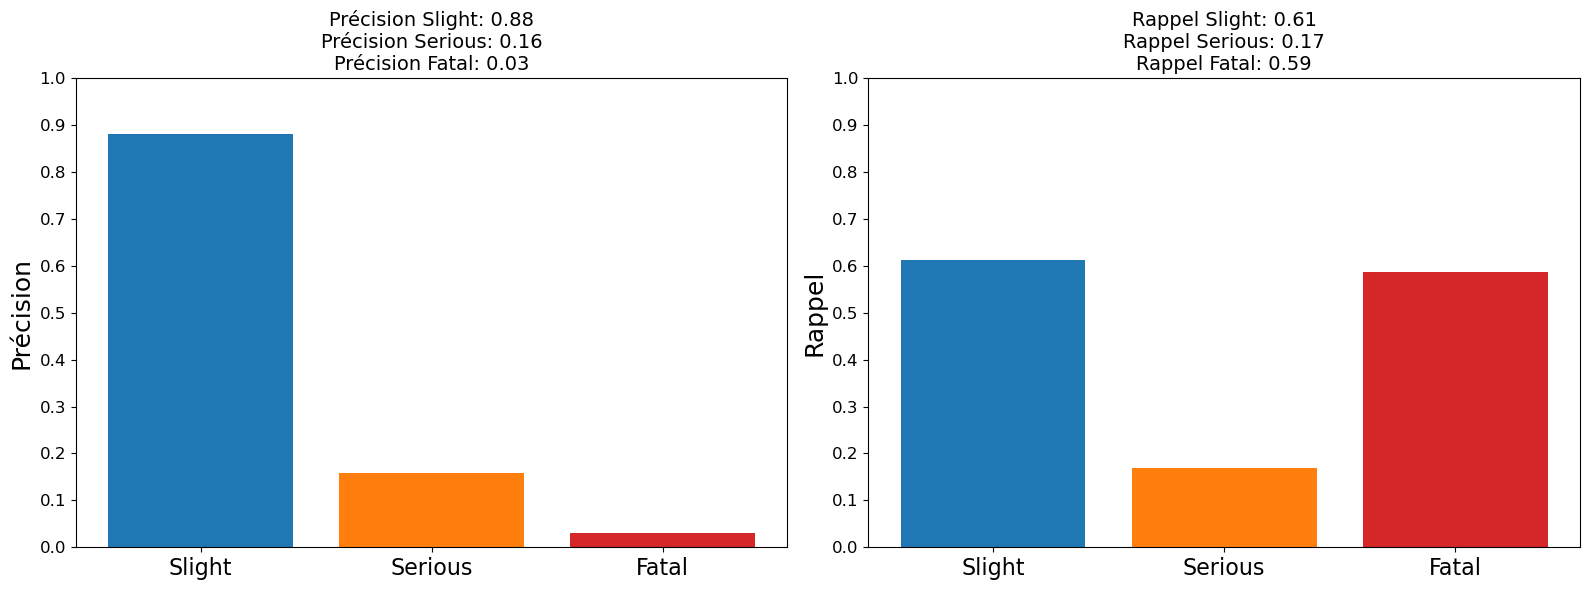


F1-scores:
F1-score Slight: 0.722
F1-score Serious: 0.163
F1-score Fatal: 0.057
Assess Test


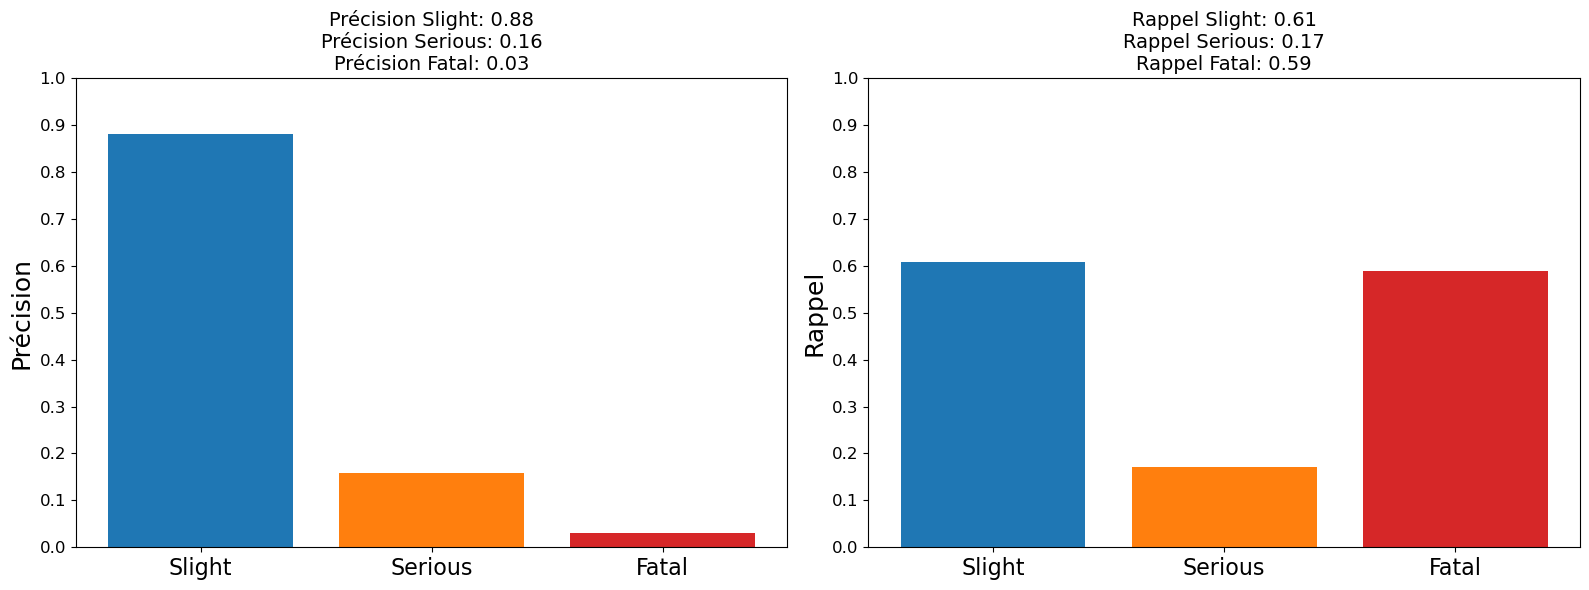


F1-scores:
F1-score Slight: 0.720
F1-score Serious: 0.164
F1-score Fatal: 0.056


In [6]:
print("Assess Train")
get_precisions_recalls(labels_train, preds_train)

print("Assess Test")
get_precisions_recalls(labels_test, preds_test)

# Solution 1: Upweight the Minority Class

In [88]:
MAJORITY_CLASS = 'Slight'
MINORITY_CLASSES = ['Serious', 'Fatal']

# 1. Calculer le nombre d'échantillons pour chaque classe
count_slight = np.sum(labels_train == MAJORITY_CLASS)
count_serious = np.sum(labels_train == MINORITY_CLASSES[0])
count_fatal = np.sum(labels_train == MINORITY_CLASSES[1])

# 2. Initialiser le dictionnaire de poids
class_weights = {}

# 3. Calculer les poids
# Le poids de la classe majoritaire est généralement fixé à 1.
class_weights[MAJORITY_CLASS] = 1.0

# Les poids des classes minoritaires sont calculés par la formule :
# Poids = (Count de la classe Majoritaire) / (Count de la classe Minoritaire)

# Poids pour 'Serious'
if count_serious > 0:
    class_weights[MINORITY_CLASSES[0]] = count_slight / count_serious
else:
    # Si la classe est absente, on peut lui donner un poids très élevé ou 0 si on veut l'ignorer.
    # Dans ce contexte, il est plus sûr d'utiliser une autre méthode (ex: 'balanced') ou de lever une alerte.
    class_weights[MINORITY_CLASSES[0]] = 0 

# Poids pour 'Fatal'
if count_fatal > 0:
    class_weights[MINORITY_CLASSES[1]] = count_slight / count_fatal
else:
    class_weights[MINORITY_CLASSES[1]] = 0

print("Poids calculés :", class_weights)

Poids calculés : {'Slight': 1.0, 'Serious': 6.304795817864989, 'Fatal': 63.84119677790564}


In [89]:
clf = DecisionTreeClassifier(
    criterion= "entropy",
    class_weight=class_weights,
    max_depth = 10,
    min_samples_leaf= 50,
    min_samples_split = 100, #nécessite 100 échantillons pour splitter
     ) #utilise le dictionnaire class_weights
clf.fit(X_train, labels_train)

preds_train = clf.predict(X_train)
preds_test = clf.predict(X_test)

clf_visual = DecisionTreeClassifier(
    criterion="entropy",
    class_weight=class_weights,
    max_depth=4,  #  Limiter à 4 niveaux pour lisibilité
    min_samples_leaf=50,
    min_samples_split=100,
    random_state=42
).fit(X_train, labels_train)

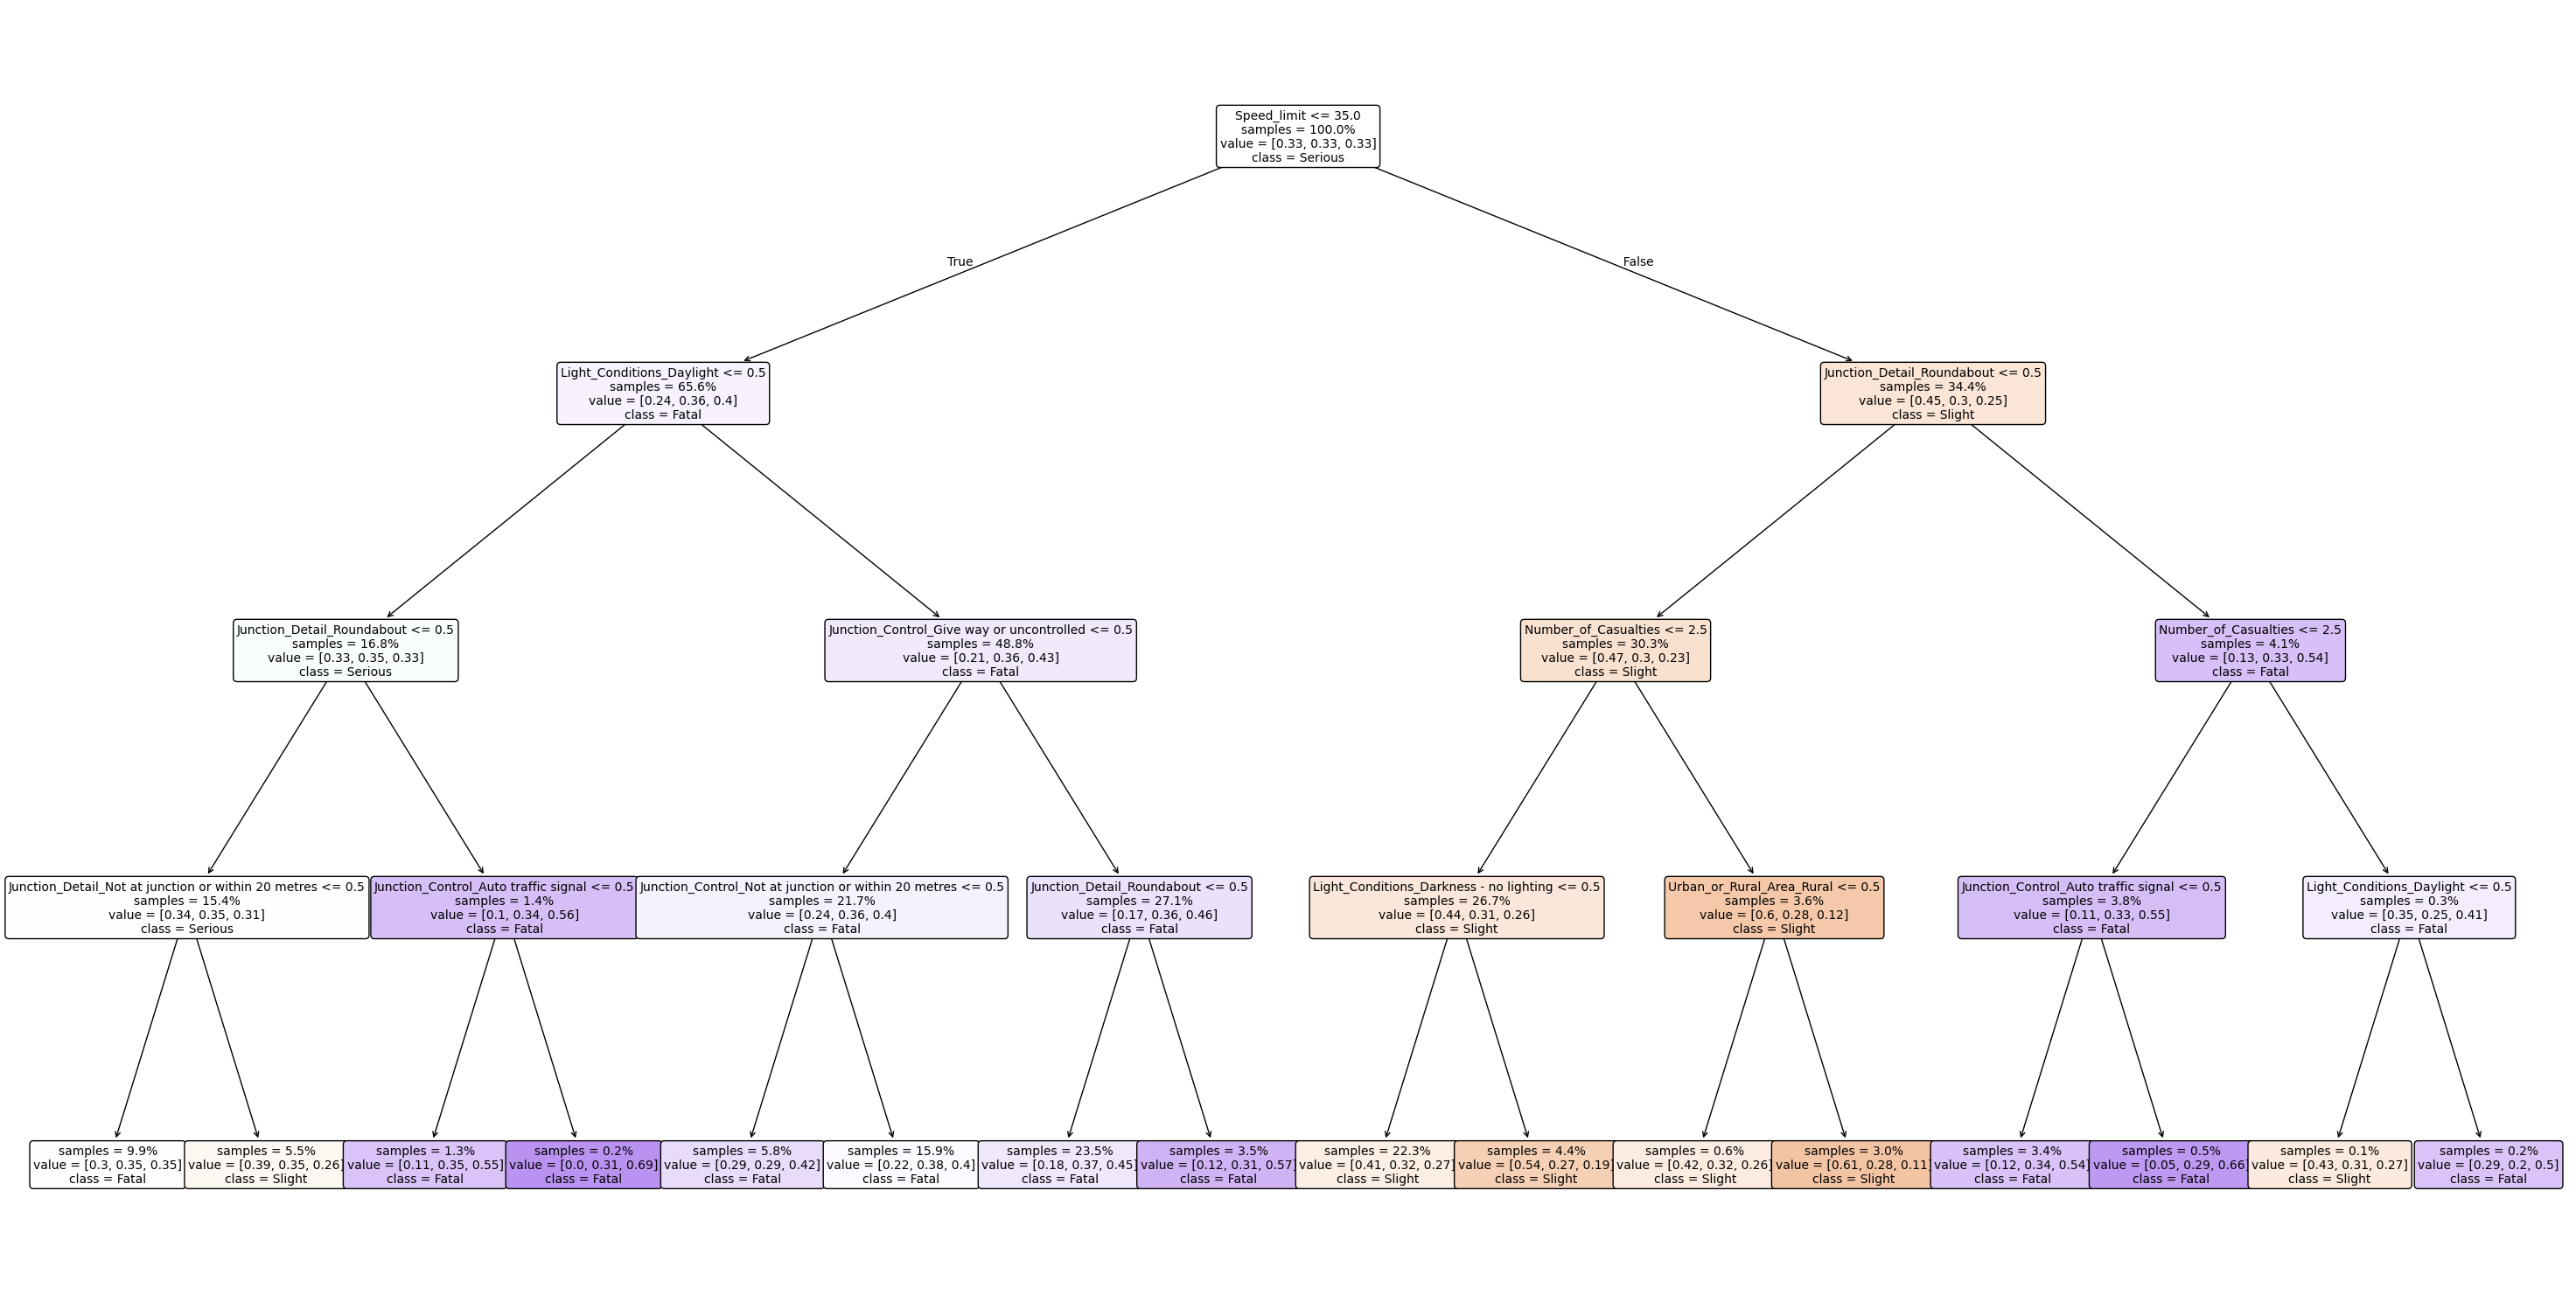

In [90]:

plt.figure(figsize=(30, 15))
plot_tree(
    clf_visual,
    feature_names=feature_names, # Pour nommer les conditions de split
    class_names=['Slight', 'Serious', 'Fatal'],        # Pour nommer les feuilles finales
    filled=True,                                       # Pour colorer les noeuds par classe
    rounded=True,
    impurity=False,
    proportion=True,
    precision=2,
    fontsize=10
)
plt.tight_layout()
plt.show()

Assess Train


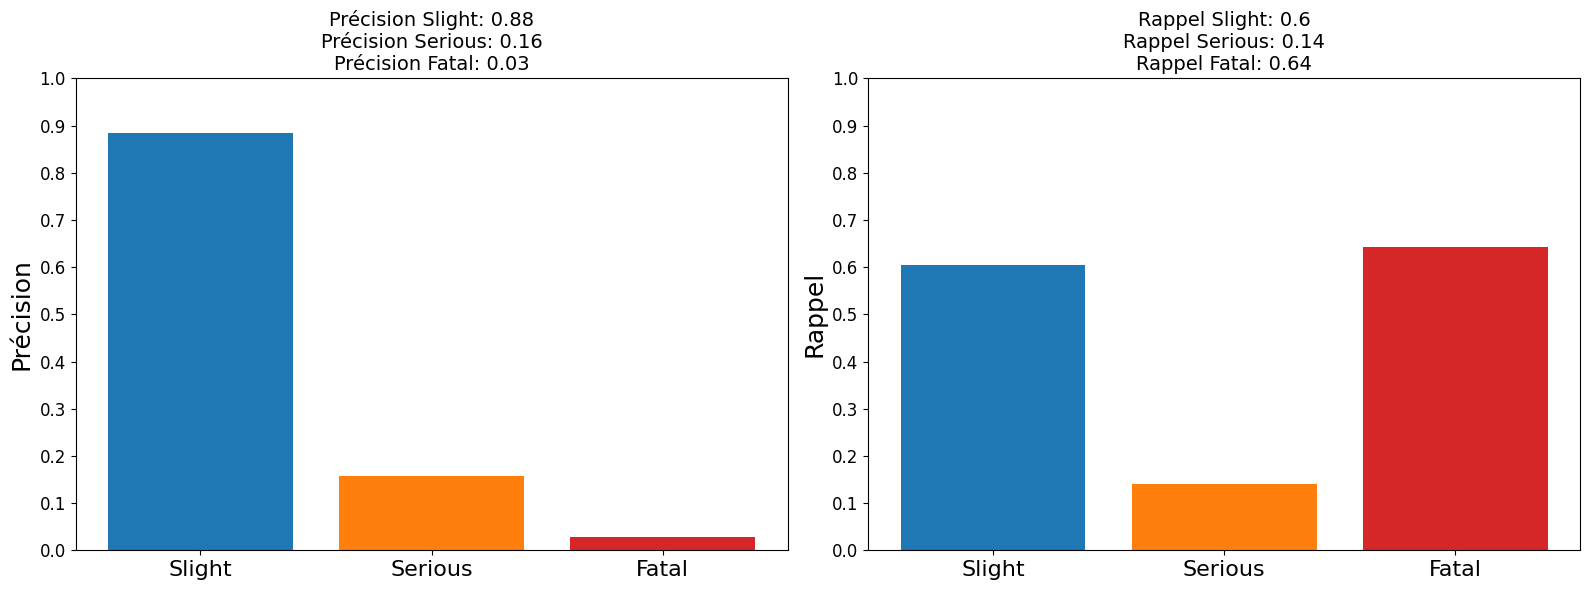


F1-scores:
F1-score Slight: 0.718
F1-score Serious: 0.148
F1-score Fatal: 0.053
Assess Test


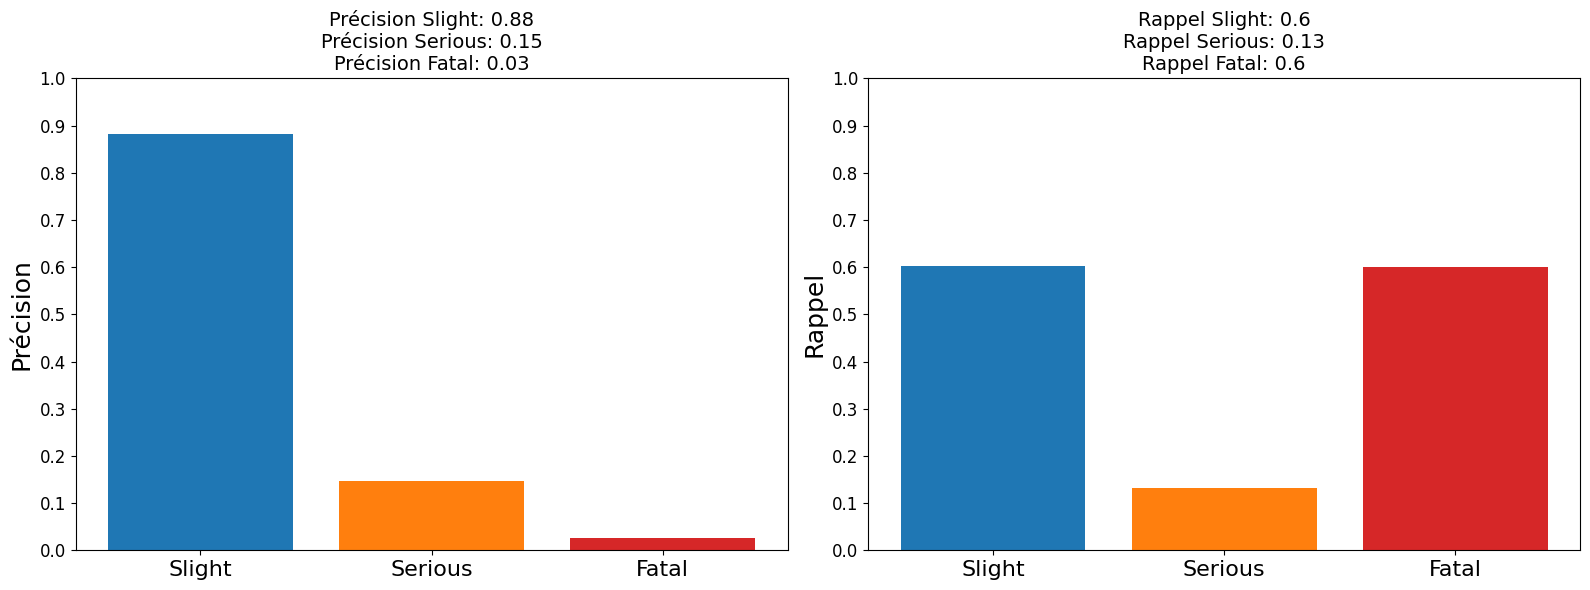


F1-scores:
F1-score Slight: 0.716
F1-score Serious: 0.138
F1-score Fatal: 0.050


In [35]:
print("Assess Train")
get_precisions_recalls(labels_train, preds_train)

print("Assess Test")
get_precisions_recalls(labels_test, preds_test)

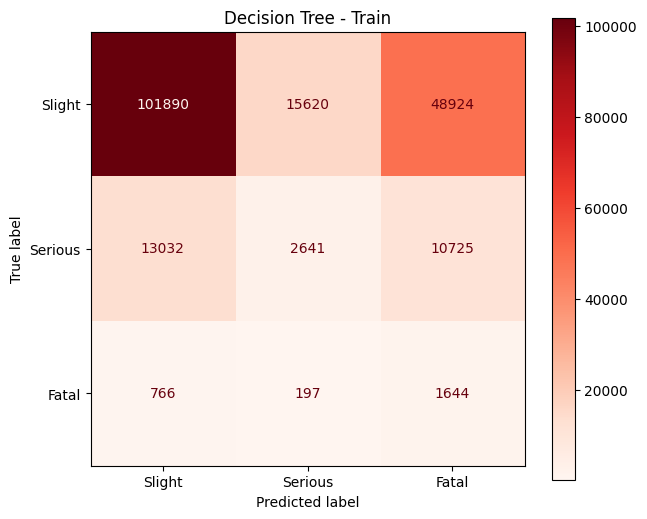

--- Rapport détaillé : Decision Tree - Train ---
              precision    recall  f1-score   support

      Slight       0.03      0.63      0.05      2607
     Serious       0.14      0.10      0.12     26398
       Fatal       0.88      0.61      0.72    166434

    accuracy                           0.54    195439
   macro avg       0.35      0.45      0.30    195439
weighted avg       0.77      0.54      0.63    195439



In [187]:
plot_confusion_multi(labels_train, preds_train, "Decision Tree - Train")

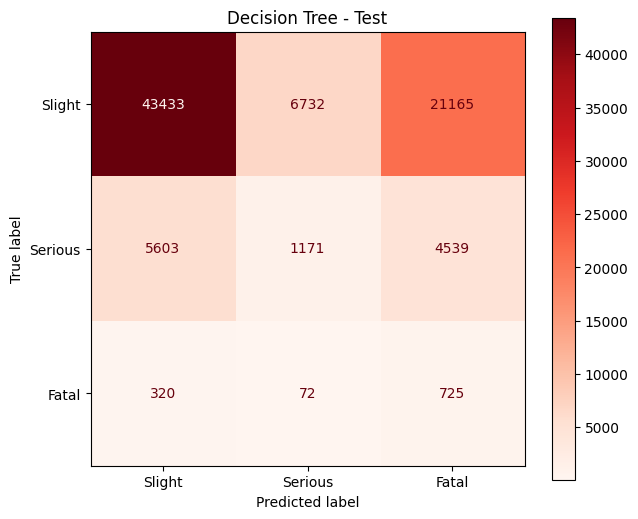

--- Rapport détaillé : Decision Tree - Test ---
              precision    recall  f1-score   support

      Slight       0.03      0.65      0.05      1117
     Serious       0.15      0.10      0.12     11313
       Fatal       0.88      0.61      0.72     71330

    accuracy                           0.54     83760
   macro avg       0.35      0.45      0.30     83760
weighted avg       0.77      0.54      0.63     83760



In [188]:
plot_confusion_multi(labels_test, preds_test, "Decision Tree - Test")

# Solution 2: SMOTE (Synthetic Minority Oversampling TEchnique)


We tested to equally distribute the three modality of the Accident_Severity but it induced a permanent overfitting.

In [36]:
from imblearn.over_sampling import SMOTE, BorderlineSMOTE, ADASYN
from collections import Counter

print("Distribution originale:", Counter(labels_train))
# Exemple: {'Slight': 184296, 'Serious': 28000, 'Fatal': 2800}

# STRATÉGIE MODÉRÉE : Augmenter Fatal à seulement 10-20% de la majorité
# Au lieu de 184k, viser 20k-40k
smote_moderate = BorderlineSMOTE(
    sampling_strategy={
        'Fatal': 20000,      # 10x l'original
        'Serious': 50000     # Oversampling modéré aussi
    },
    random_state=42,
    k_neighbors=3  # Moins de voisins = moins de sur-généralisation
)

X_train_sampled, labels_train_sampled = smote_moderate.fit_resample(X_train, labels_train)
print("Distribution après SMOTE modéré:", Counter(labels_train_sampled))

Distribution originale: Counter({'Slight': 184296, 'Serious': 28518, 'Fatal': 2767})
Distribution après SMOTE modéré: Counter({'Slight': 184296, 'Serious': 50000, 'Fatal': 20000})


In [37]:
#modification of min_samples_leaf started at 1000, 2000 and finished with 5000 bu still got overfitting
clf = DecisionTreeClassifier(
    criterion= "entropy",
    class_weight='balanced',
    min_samples_leaf= 5000, # 1000 is 0.18% of dataset oversampled 3 identical number of data still got overfitting
    min_samples_split=15000, # 3X min_samples_leaf
    max_depth =5,# even with 10 overfitting
    random_state=42) 
clf.fit(X_train_sampled, labels_train_sampled)

preds_train = clf.predict(X_train_sampled)
preds_test = clf.predict(X_test)

Assess Train


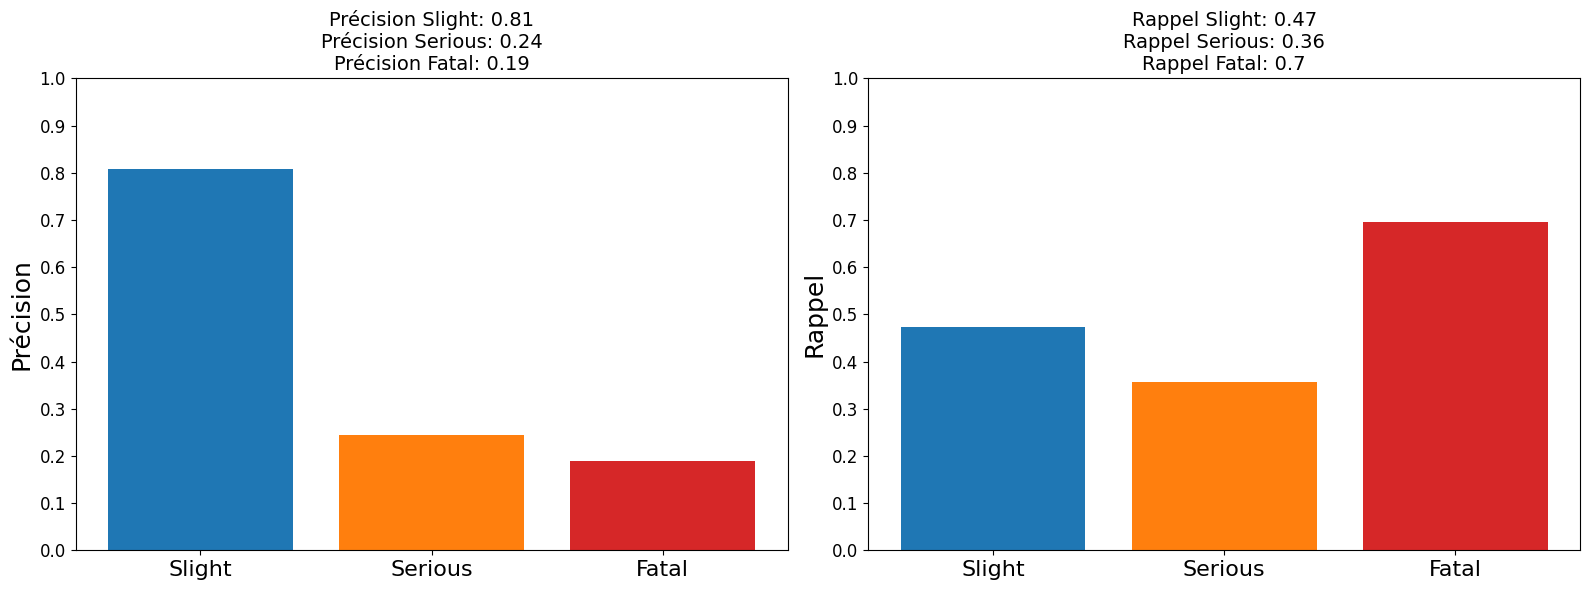


F1-scores:
F1-score Slight: 0.597
F1-score Serious: 0.290
F1-score Fatal: 0.298
Assess Test


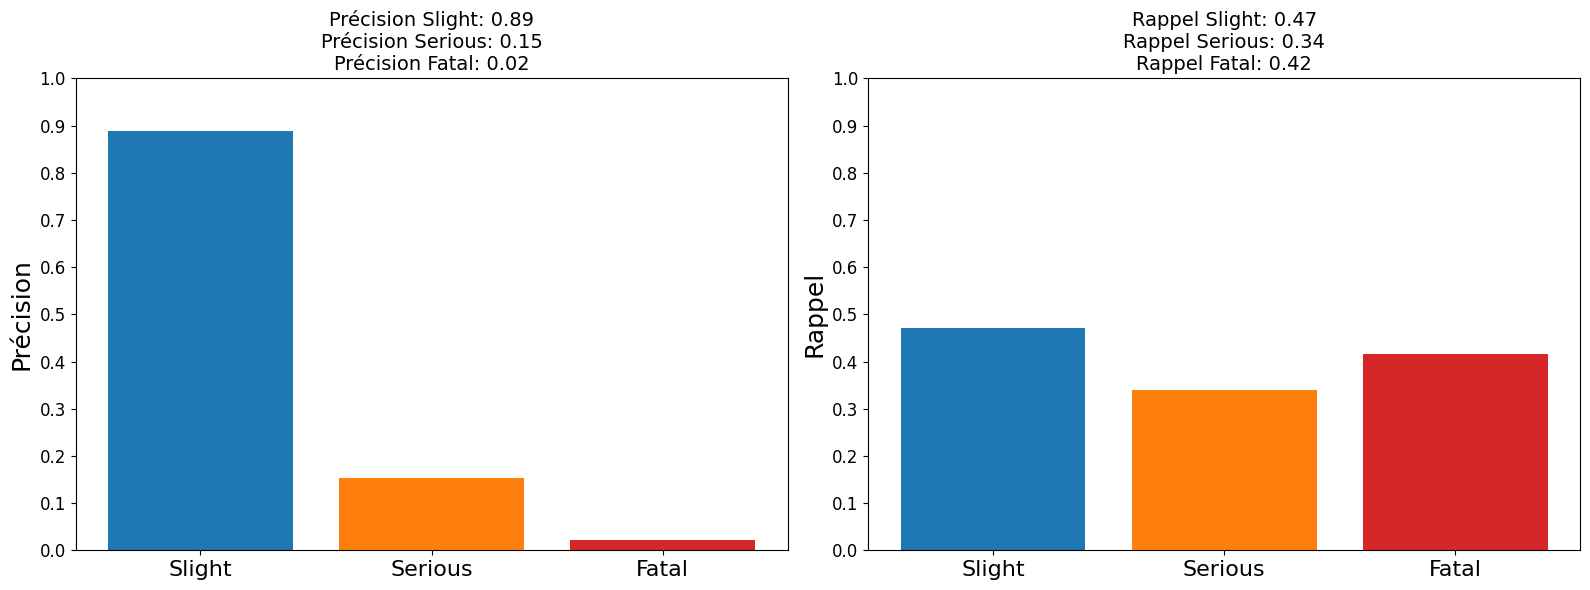


F1-scores:
F1-score Slight: 0.616
F1-score Serious: 0.210
F1-score Fatal: 0.040


In [38]:
print("Assess Train")
get_precisions_recalls(labels_train_sampled, preds_train)

print("Assess Test")
get_precisions_recalls(labels_test, preds_test)

#  Random Forest
 

## Solution 3 : Balanced Random Forest 
Each tree is trained on the same 3.000 Fatal data but a different sample  of 3.000 data is randomy picked from the Serious and  

In [101]:
from imblearn.ensemble import BalancedRandomForestClassifier

In [190]:
# Le paramètre sampling_strategy='not minority' assure que les classes 
# majoritaires sont sous-échantillonnées pour correspondre à la minoritaire.
brf = BalancedRandomForestClassifier(
    criterion='entropy',
    n_estimators=300, 
    sampling_strategy='not minority', 
    replacement=False, 
    random_state=42,
    min_samples_split =35,
    min_samples_leaf=10,
    max_depth=25,
    bootstrap=True
)

index_casualties = list(feature_names).index('Number_of_Casualties')
print(f"L'index à supprimer est : {index_casualties}")

# Puis utilisez cet index dans np.delete :
X_train_clean = np.delete(X_train, index_casualties, axis=1)
X_test_clean = np.delete(X_test, index_casualties, axis=1)

brf.fit(X_train, labels_train)

preds_train = brf.predict(X_train)
preds_test = brf.predict(X_test)

L'index à supprimer est : 1


Assess Train


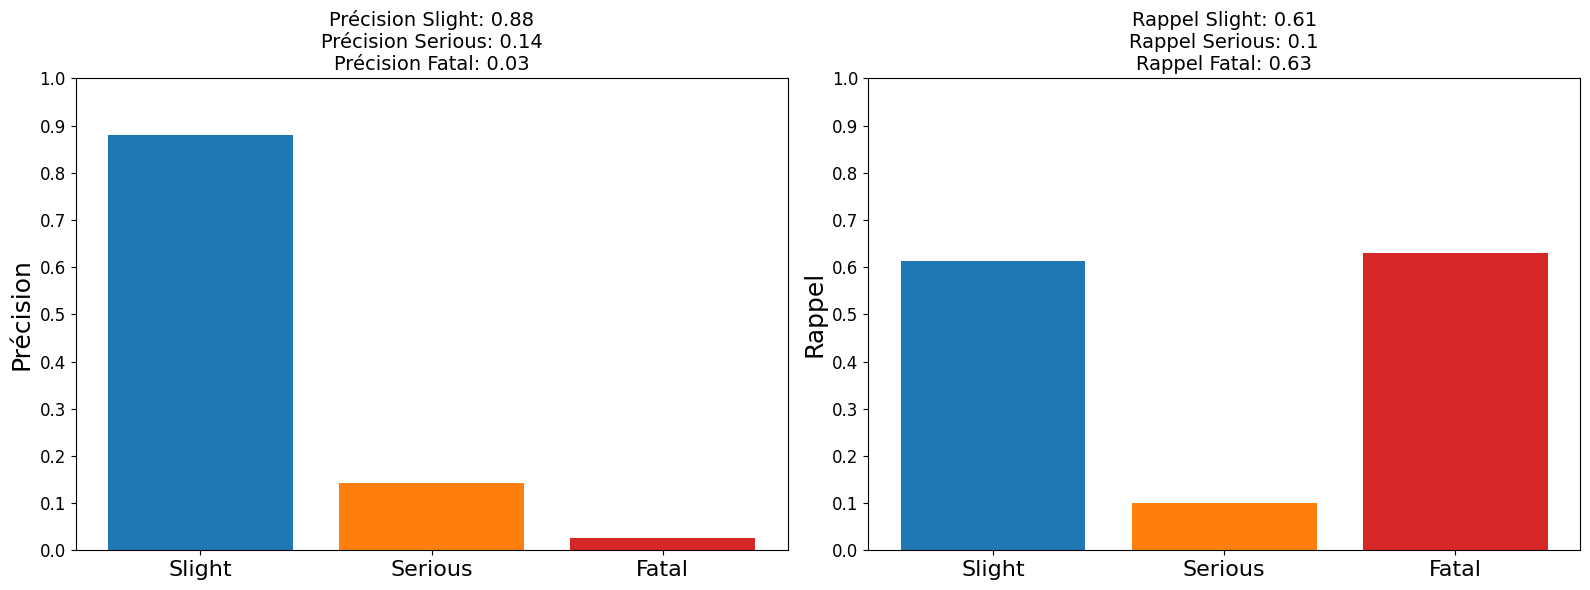


F1-scores:
F1-score Slight: 0.722
F1-score Serious: 0.118
F1-score Fatal: 0.051
Assess Test


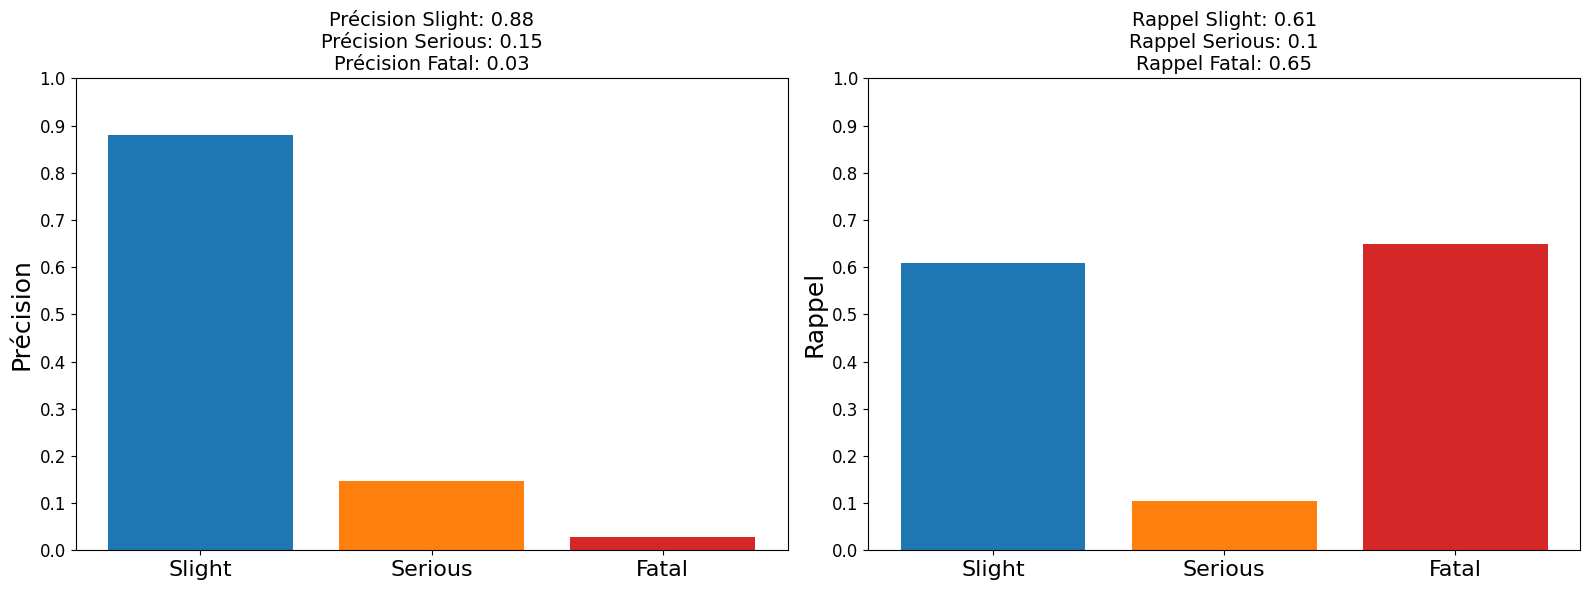


F1-scores:
F1-score Slight: 0.720
F1-score Serious: 0.121
F1-score Fatal: 0.053


In [174]:
print("Assess Train")
get_precisions_recalls(labels_train, preds_train)

print("Assess Test")
get_precisions_recalls(labels_test, preds_test)

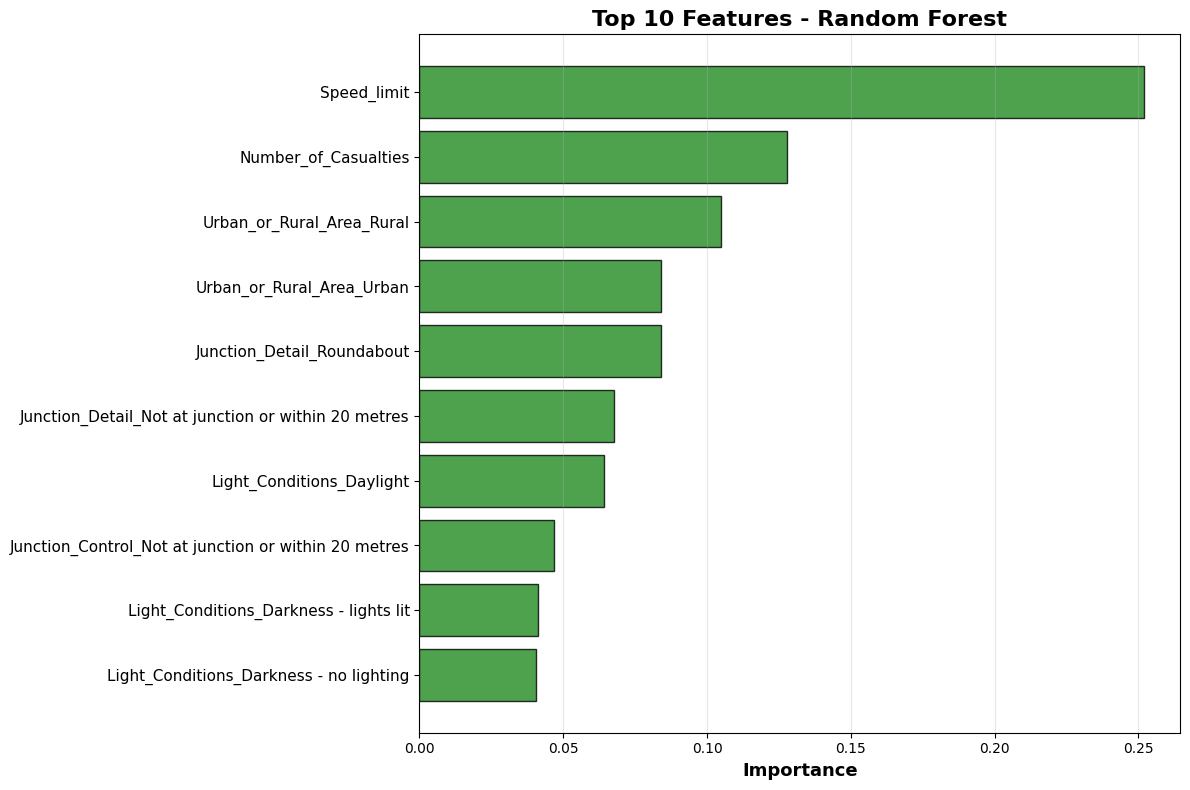


=== TOP 10 FEATURES ===
 1. Speed_limit                              : 0.2519
 2. Number_of_Casualties                     : 0.1278
 3. Urban_or_Rural_Area_Rural                : 0.1048
 4. Urban_or_Rural_Area_Urban                : 0.0840
 5. Junction_Detail_Roundabout               : 0.0839
 6. Junction_Detail_Not at junction or within 20 metres : 0.0676
 7. Light_Conditions_Daylight                : 0.0642
 8. Junction_Control_Not at junction or within 20 metres : 0.0468
 9. Light_Conditions_Darkness - lights lit   : 0.0413
10. Light_Conditions_Darkness - no lighting  : 0.0405


In [104]:
# === FEATURE IMPORTANCE ===
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

# Garder top 10
n_features=len(feature_names)
top_n = min(10,n_features)
top_indices = indices[:top_n]
top_features = [feature_names[i] for i in top_indices]
top_importances = importances[top_indices]

# Visualisation
plt.figure(figsize=(12, 8))
plt.barh(range(top_n), top_importances[::-1], color='forestgreen', alpha=0.8, edgecolor='black')
plt.yticks(range(top_n), top_features[::-1], fontsize=11)
plt.xlabel('Importance', fontsize=13, fontweight='bold')
plt.title('Top 10 Features - Random Forest', fontsize=16, fontweight='bold')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

# Afficher les valeurs
print("\n=== TOP 10 FEATURES ===")
for i, (feat, imp) in enumerate(zip(top_features, top_importances), 1):
    print(f"{i:2d}. {feat:<40} : {imp:.4f}")

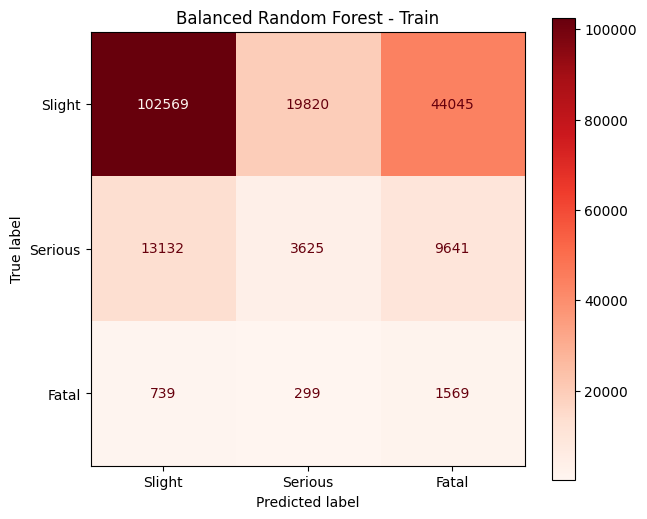

--- Rapport détaillé : Balanced Random Forest - Train ---
              precision    recall  f1-score   support

      Slight       0.03      0.60      0.05      2607
     Serious       0.15      0.14      0.14     26398
       Fatal       0.88      0.62      0.73    166434

    accuracy                           0.55    195439
   macro avg       0.35      0.45      0.31    195439
weighted avg       0.77      0.55      0.64    195439



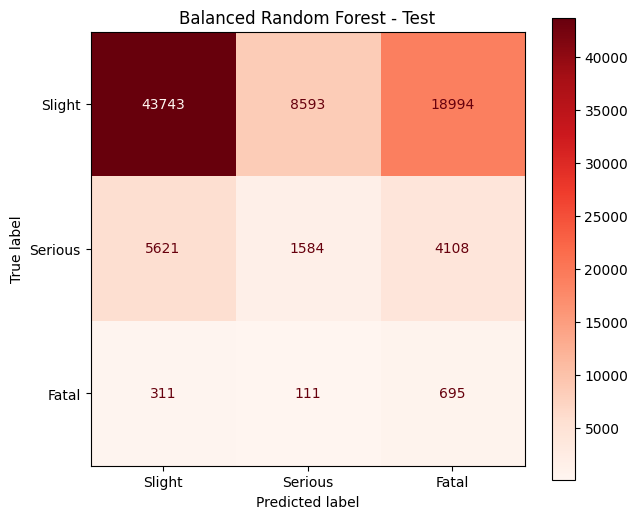

--- Rapport détaillé : Balanced Random Forest - Test ---
              precision    recall  f1-score   support

      Slight       0.03      0.62      0.06      1117
     Serious       0.15      0.14      0.15     11313
       Fatal       0.88      0.61      0.72     71330

    accuracy                           0.55     83760
   macro avg       0.35      0.46      0.31     83760
weighted avg       0.77      0.55      0.64     83760



In [191]:
plot_confusion_multi(labels_train, preds_train, "Balanced Random Forest - Train")
plot_confusion_multi(labels_test, preds_test, "Balanced Random Forest - Test")

## Solution 4 : Undersampling Manuel

In [109]:
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier

In [110]:
# --- 1. Analyser la distribution originale ---
print("Distribution originale:")
print(Counter(labels_train))
# Exemple: {'Slight': 184296, 'Serious': 28000, 'Fatal': 2800}

# --- 2. Stratégie d'undersampling ---
# Option A : Équilibrer toutes les classes (le plus agressif)
undersampler_balanced = RandomUnderSampler(
    sampling_strategy='auto',  # Toutes les classes = taille de la minorité
    random_state=42
)
# Option B : Undersampling modéré (recommandé)
# Réduire Slight à 5-10x la classe minoritaire
n_fatal = Counter(labels_train)['Fatal']
n_serious = Counter(labels_train)['Serious']

undersampler_moderate = RandomUnderSampler(
    sampling_strategy={
        'Slight': n_fatal * 10,    # Slight = 10x Fatal (~28,000)
        'Serious': n_fatal * 5,    # Serious = 5x Fatal (~14,000)
        'Fatal': n_fatal           # Fatal = inchangé (~2,800)
    },
    random_state=42
)

Distribution originale:
Counter({'Slight': 184296, 'Serious': 28518, 'Fatal': 2767})


In [111]:
# --- 3. Appliquer l'undersampling (choisir une option) ---
X_train_undersampled, labels_train_undersampled = undersampler_moderate.fit_resample(
    X_train, labels_train
)

print("\nDistribution après undersampling:")
print(Counter(labels_train_undersampled))
print(f"Taille dataset: {len(labels_train_undersampled)} échantillons")


Distribution après undersampling:
Counter({'Slight': 27670, 'Serious': 13835, 'Fatal': 2767})
Taille dataset: 44272 échantillons


In [ ]:
rf = RandomForestClassifier(
    n_estimators=300,
    
    # Paramètres adaptés au dataset plus petit
    max_depth=10,              # Peut être plus profond (moins de données)
    min_samples_leaf=50,       # Plus petit (dataset réduit)
    min_samples_split=100,
    
    # Boost supplémentaire pour Fatal
    class_weight= 'balanced',
    bootstrap=True,
    random_state=42,
)

rf.fit(X_train_undersampled, labels_train_undersampled)

preds_train = rf.predict(X_train_undersampled)
preds_test = rf.predict(X_test)

Overfitting

Assess Train


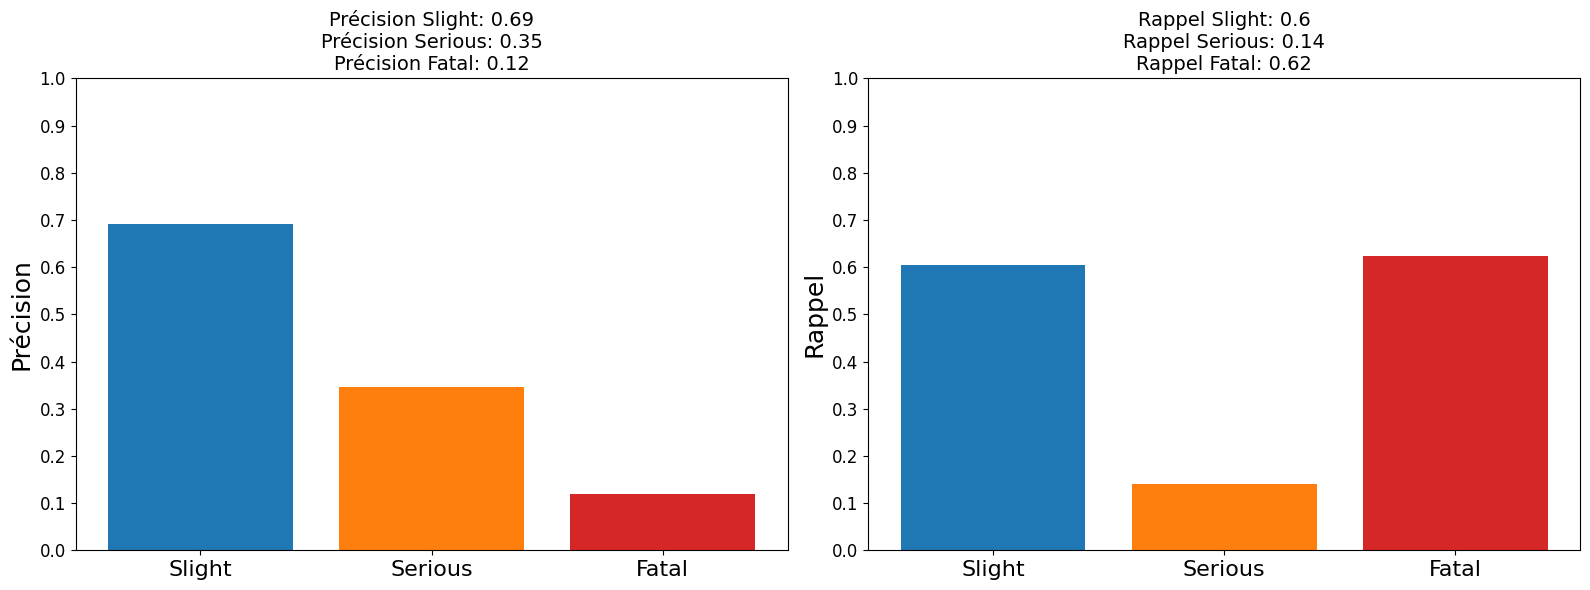


F1-scores:
F1-score Slight: 0.645
F1-score Serious: 0.199
F1-score Fatal: 0.200
Assess Test


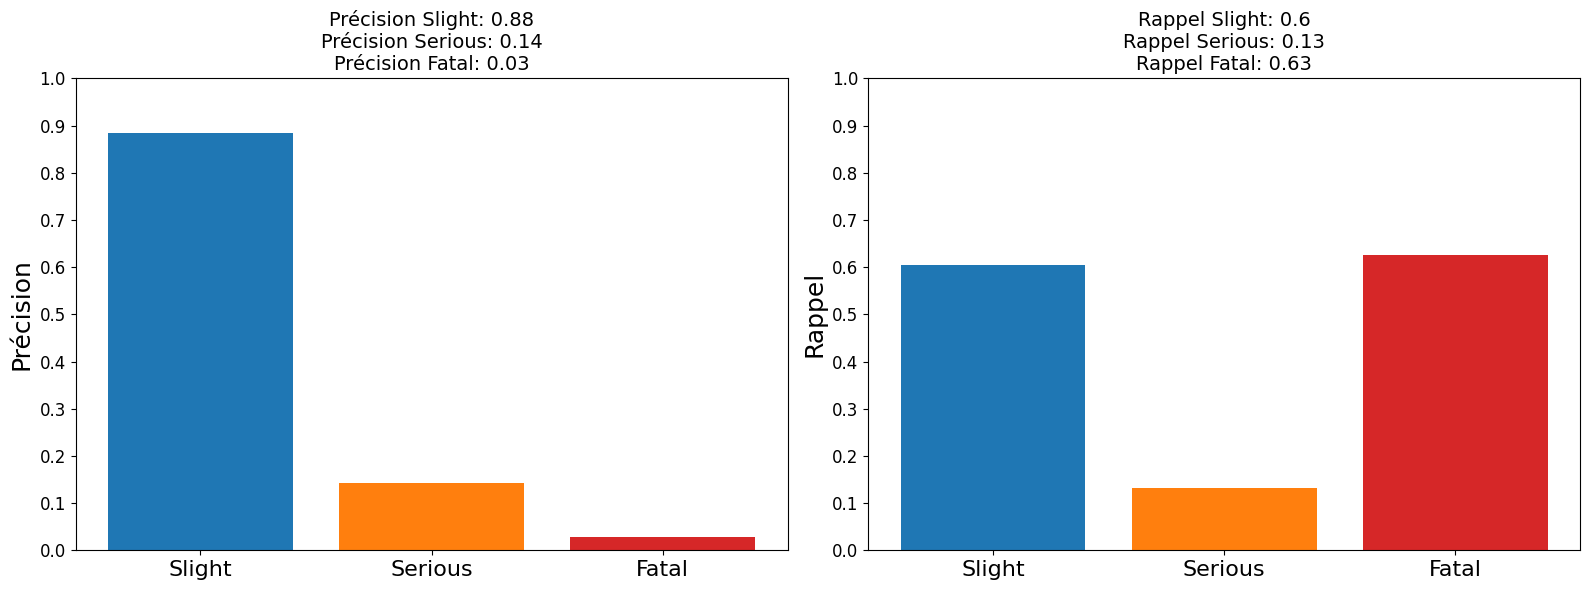


F1-scores:
F1-score Slight: 0.717
F1-score Serious: 0.137
F1-score Fatal: 0.052


In [113]:
print("Assess Train")
get_precisions_recalls(labels_train_undersampled, preds_train)

print("Assess Test")
get_precisions_recalls(labels_test, preds_test)

# Solution 5 : Boosting

In [47]:
import xgboost as xgb

In [116]:

# Encoder les labels en numérique
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train_encoded = le.fit_transform(labels_train)
y_test_encoded = le.transform(labels_test)

# Calculer les poids de classe
class_counts = Counter(y_train_encoded)
total = sum(class_counts.values())
class_weights = {cls: total / (len(class_counts) * count) for cls, count in class_counts.items()}

print("Class weights:", class_weights)
# Exemple: {0: 1.01 (Slight), 1: 7.9 (Serious), 2: 78.9 (Fatal)}

print("\nClass weights :")
for cls_id, weight in class_weights.items():
    cls_name = le.inverse_transform([cls_id])[0]
    print(f"  {cls_name} ({cls_id}): {weight:.2f}")

sample_weights = np.array([class_weights[y] for y in y_train_encoded])

Class weights: {2: 0.39142442850218906, 1: 2.467851099830795, 0: 24.98900396368751}

Class weights :
  Slight (2): 0.39
  Serious (1): 2.47
  Fatal (0): 24.99


In [193]:
# XGBoost avec scale_pos_weight
xgb_clf = xgb.XGBClassifier(
    # Paramètres anti-overfitting
    max_depth=6,                    # Peu profond (3-8)
    min_child_weight=10,            # Nécessite 10+ échantillons par feuille
    
    # Régularisation
    gamma=1,                        # Pénalité de complexité (0-5)
    subsample=0.8,                  # 80% des données par arbre
    colsample_bytree=0.8,           # 80% des features par arbre
    reg_alpha=1,                    # Régularisation L1
    reg_lambda=10,                  # Régularisation L2
    
    # Boosting
    n_estimators=300,
    learning_rate=0.05,             # Faible = meilleure généralisation
    
    
    # Autres
    objective='multi:softprob',
    num_class=3,
    eval_metric='mlogloss',
    random_state=42,
    n_jobs=-1,
    early_stopping_rounds=20        # Arrêt si pas d'amélioration
)

# Entraînement avec validation
xgb_clf.fit(
    X_train, y_train_encoded,
    sample_weight = sample_weights,
    eval_set=[(X_test, y_test_encoded)],
    verbose=50
)

# Prédiction
preds_train = xgb_clf.predict(X_train)
preds_test = xgb_clf.predict(X_test)


[0]	validation_0-mlogloss:1.09476
[50]	validation_0-mlogloss:1.03542
[100]	validation_0-mlogloss:1.02979
[150]	validation_0-mlogloss:1.02905


Assess Train


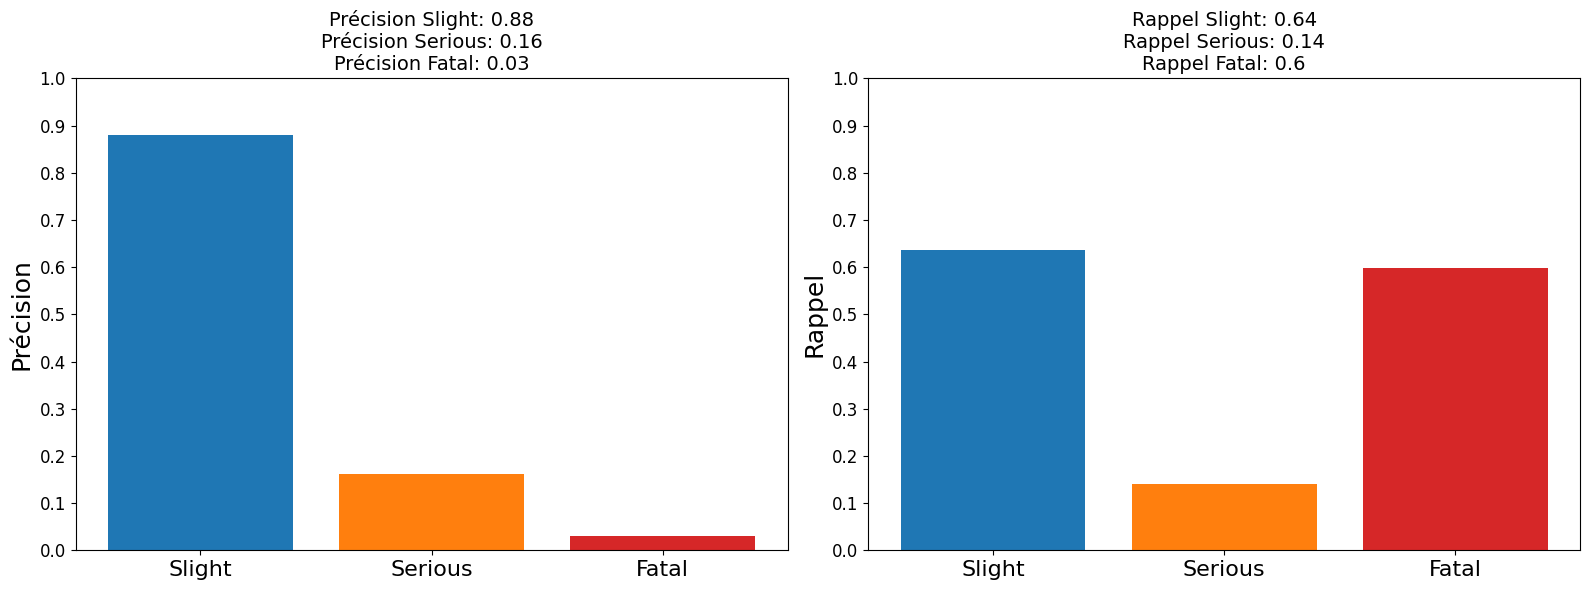


F1-scores:
F1-score Slight: 0.738
F1-score Serious: 0.151
F1-score Fatal: 0.057
Assess Test


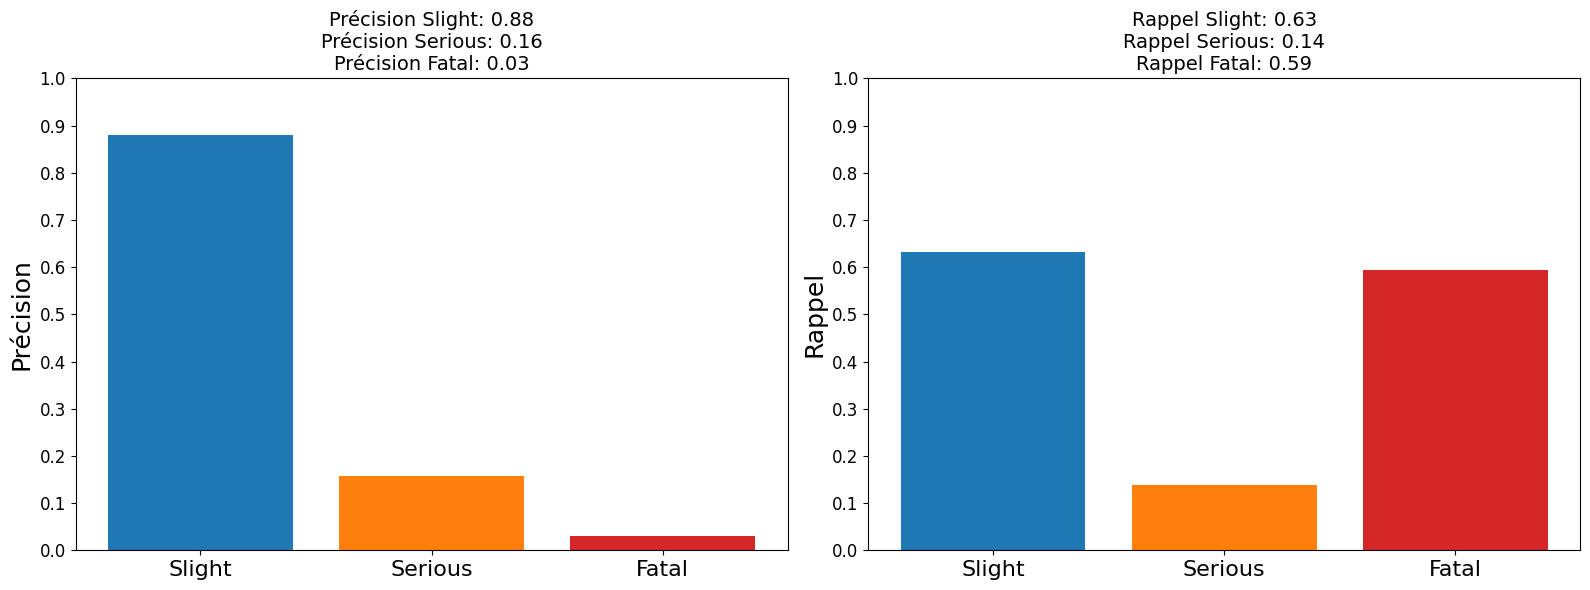


F1-scores:
F1-score Slight: 0.736
F1-score Serious: 0.146
F1-score Fatal: 0.056


In [198]:
# DÉCODER les prédictions ET les vraies valeurs
preds_train_labels = le.inverse_transform(preds_train)
preds_test_labels = le.inverse_transform(preds_test)
y_train_labels = le.inverse_transform(y_train_encoded)  
y_test_labels = le.inverse_transform(y_test_encoded)    

# Maintenant appeler avec les labels décodés
print("Assess Train")
get_precisions_recalls(y_train_labels, preds_train_labels)  

print("Assess Test")
get_precisions_recalls(y_test_labels, preds_test_labels)    

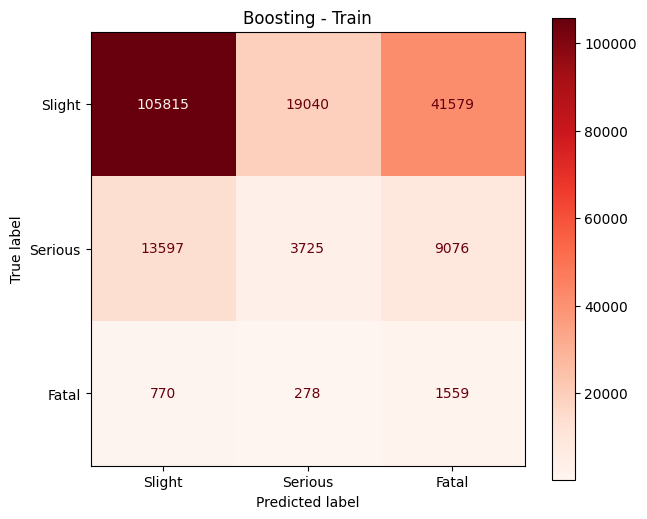

--- Rapport détaillé : Boosting - Train ---
              precision    recall  f1-score   support

      Slight       0.03      0.60      0.06      2607
     Serious       0.16      0.14      0.15     26398
       Fatal       0.88      0.64      0.74    166434

    accuracy                           0.57    195439
   macro avg       0.36      0.46      0.32    195439
weighted avg       0.77      0.57      0.65    195439



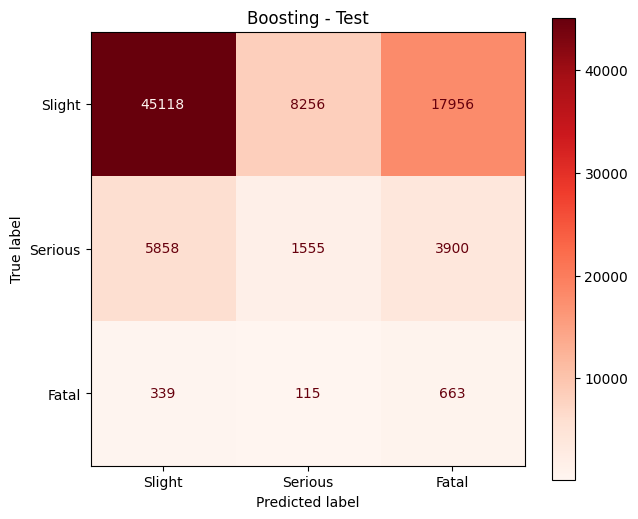

--- Rapport détaillé : Boosting - Test ---
              precision    recall  f1-score   support

      Slight       0.03      0.59      0.06      1117
     Serious       0.16      0.14      0.15     11313
       Fatal       0.88      0.63      0.74     71330

    accuracy                           0.57     83760
   macro avg       0.36      0.45      0.31     83760
weighted avg       0.77      0.57      0.65     83760



In [199]:
plot_confusion_multi(y_train_labels, preds_train_labels, "Boosting - Train")
plot_confusion_multi(y_test_labels, preds_test_labels, "Boosting - Test")

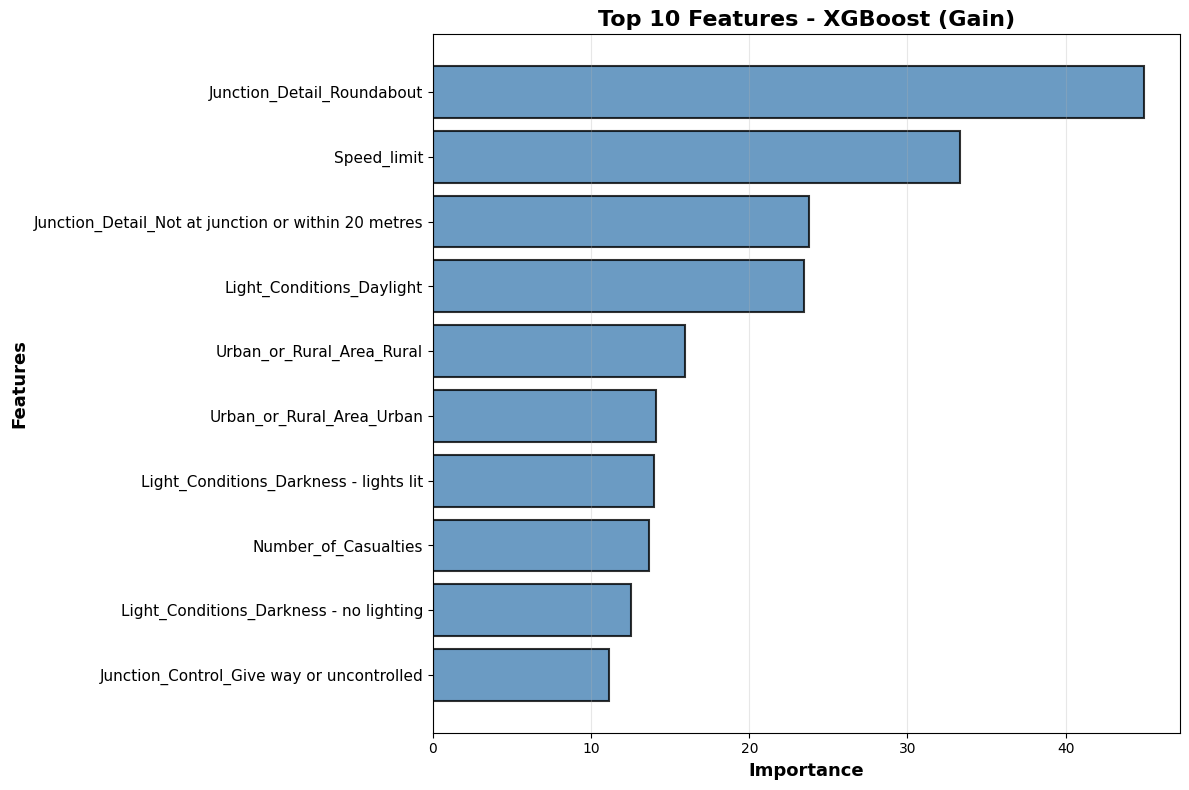

In [120]:
# === EXTRAIRE FEATURE IMPORTANCE AVEC LES VRAIS NOMS ===
# Obtenir le dictionnaire d'importance (clés = 'f0', 'f1', etc.)
importance_dict = xgb_clf.get_booster().get_score(importance_type='gain')

# 🔥 MAPPER 'f0' -> feature_names[0], 'f1' -> feature_names[1], etc.
importances_with_names = {}
for key, value in importance_dict.items():
    # Extraire le numéro (f0 -> 0, f1 -> 1, etc.)
    feature_idx = int(key[1:])  # Enlever le 'f' et convertir en int
    feature_name = feature_names[feature_idx]
    importances_with_names[feature_name] = value

# Trier par importance
sorted_features = sorted(importances_with_names.items(), key=lambda x: x[1], reverse=True)

# Top 10
top_n = min(10, len(sorted_features))
top_features = [f[0] for f in sorted_features[:top_n]]
top_importances = [f[1] for f in sorted_features[:top_n]]

# === VISUALISATION (MÊME STYLE QUE RANDOM FOREST) ===
plt.figure(figsize=(12, 8))
plt.barh(range(top_n), top_importances[::-1], 
         color='steelblue', alpha=0.8, edgecolor='black', linewidth=1.5)
plt.yticks(range(top_n), top_features[::-1], fontsize=11)
plt.xlabel('Importance', fontsize=13, fontweight='bold')
plt.ylabel('Features', fontsize=13, fontweight='bold')
plt.title(f'Top {top_n} Features - XGBoost (Gain)', fontsize=16, fontweight='bold')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

# Solution 6 : Boosting on Fatal or Non-Fatal instead of Slight or Serious or Fatal

In [145]:

def get_precisions_recalls_binary(actual, preds):
    """
    Calcule et affiche Précision, Recall et F1-Score pour classification BINAIRE.
    S'adapte si les entrées sont déjà binarisées (Fatal/Non-Fatal) ou (1/0).
    """
    # 1. PRÉPARATION DES DONNÉES
    # Conversion en chaînes pour une comparaison uniforme
    actual = np.array(actual, dtype=str)
    preds = np.array(preds, dtype=str)

    # Si les labels sont 0/1 (XGBoost), on les renomme pour le graphique
    actual = np.where(actual == '1', 'Fatal', actual)
    actual = np.where(actual == '0', 'Non-Fatal', actual)
    preds = np.where(preds == '1', 'Fatal', preds)
    preds = np.where(preds == '0', 'Non-Fatal', preds)

    classes = ['Non-Fatal', 'Fatal']
    
    # --- 2. CALCUL DES MÉTRIQUES (Sécurisé contre division par zéro) ---
    precisions = []
    recalls = []
    
    for cls in classes:
        tp = np.sum((actual == cls) & (preds == cls))
        fp = np.sum((actual != cls) & (preds == cls))
        fn = np.sum((actual == cls) & (preds != cls))
        
        # Précision = TP / (TP + FP)
        prec = tp / (tp + fp) if (tp + fp) > 0 else 0
        # Rappel = TP / (TP + FN)
        rec = tp / (tp + fn) if (tp + fn) > 0 else 0
        
        precisions.append(prec)
        recalls.append(rec)
        # F1-Score
    f1_scores = [
        2 * (precisions[i] * recalls[i]) / (precisions[i] + recalls[i])
        if (precisions[i] + recalls[i]) > 0 else 0
        for i in range(len(classes))
    ]

    # --- 3. AFFICHAGE DES GRAPHIQUES ---
    plt.figure(figsize=(14, 5))
    x_pos = np.arange(len(classes))
    colors = ['#1f77b4', '#d62728'] # Bleu pour Non-Fatal, Rouge pour Fatal

    # Graphique Précision
    plt.subplot(1, 2, 1)
    plt.bar(x_pos, precisions, color=colors)
    plt.xticks(x_pos, classes, fontsize=14)
    plt.ylim(0, 1.1)
    plt.ylabel('Précision', fontsize=16)
    plt.title(f"Précision\nNon-Fatal: {precisions[0]:.2f} | Fatal: {precisions[1]:.2f}")

    # Graphique Rappel
    plt.subplot(1, 2, 2)
    plt.bar(x_pos, recalls, color=colors)
    plt.xticks(x_pos, classes, fontsize=14)
    plt.ylim(0, 1.1)
    plt.ylabel('Rappel', fontsize=16)
    plt.title(f"Rappel\nNon-Fatal: {recalls[0]:.2f} | Fatal: {recalls[1]:.2f}")

    plt.tight_layout()
    plt.show()

    # --- 4. SORTIE TERMINAL ---
    print(f"{'Classe':<12} | {'F1-Score':<10}")
    print("-" * 25)
    for i, cls in enumerate(classes):
        print(f"{cls:<12} | {f1_scores[i]:.3f}")

In [146]:
#Créer labels binaires : 1 = Fatal, 0 = Non-Fatal (Slight + Serious)
y_train_binary = (labels_train == 'Fatal').astype(int)
y_test_binary = (labels_test == 'Fatal').astype(int)

print("\nDistribution TRAIN:")
counts_train = Counter(y_train_binary)
print(f"  Non-Fatal (0): {counts_train[0]:>6} ({counts_train[0]/len(y_train_binary)*100:.1f}%)")
print(f"  Fatal (1):     {counts_train[1]:>6} ({counts_train[1]/len(y_train_binary)*100:.1f}%)")

print("\nDistribution TEST:")
counts_test = Counter(y_test_binary)
print(f"  Non-Fatal (0): {counts_test[0]:>6} ({counts_test[0]/len(y_test_binary)*100:.1f}%)")
print(f"  Fatal (1):     {counts_test[1]:>6} ({counts_test[1]/len(y_test_binary)*100:.1f}%)")


Distribution TRAIN:
  Non-Fatal (0): 192832 (98.7%)
  Fatal (1):       2607 (1.3%)

Distribution TEST:
  Non-Fatal (0):  82643 (98.7%)
  Fatal (1):       1117 (1.3%)


In [201]:
# --- 3. XGBOOST BINAIRE ---
print("\n" + "="*70)
print("ENTRAÎNEMENT XGBOOST BINAIRE")
print("="*70)

ratio = counts_train[0] / counts_train[1]

xgb_binary = xgb.XGBClassifier(
    # Architecture
    max_depth=8,                    # Peut être plus profond en binaire
    min_child_weight=10,
    
    # Régularisation
    gamma=0.5,
    subsample=0.8,
    colsample_bytree=0.8,
    colsample_bylevel=0.8,
    reg_alpha=0.5,
    reg_lambda=5,
    
    # Boosting
    n_estimators=500,
    learning_rate=0.05,
    
    scale_pos_weight= ratio,
    # Binaire
    objective='binary:logistic',
    eval_metric=['logloss', 'error', 'aucpr'],  # AUC-PR important pour déséquilibre
    
    # Early stopping
    early_stopping_rounds=30,
    
    random_state=42,
    n_jobs=-1,
    tree_method='hist',
)

# Entraînement
xgb_binary.fit(
    X_train, y_train_binary,
    eval_set=[(X_train, y_train_binary), (X_test, y_test_binary)],
    verbose=50
)

# Prédiction
preds_train = xgb_binary.predict(X_train)
preds_test = xgb_binary.predict(X_test)


ENTRAÎNEMENT XGBOOST BINAIRE
[0]	validation_0-logloss:0.68639	validation_0-error:0.33915	validation_0-aucpr:0.03937	validation_1-logloss:0.68648	validation_1-error:0.33996	validation_1-aucpr:0.04113
[38]	validation_0-logloss:0.60703	validation_0-error:0.31718	validation_0-aucpr:0.04712	validation_1-logloss:0.60907	validation_1-error:0.31984	validation_1-aucpr:0.04655


In [221]:
y_scores = xgb_binary.predict_proba(X_test)[:, 1] 

# Créer un DataFrame pour analyser
results = pd.DataFrame({'Score_Risque': y_scores, 'Realité': labels_test})
# Trier par score décroissant pour voir si les "Fatal" sont bien en haut
print(results.sort_values(by='Score_Risque', ascending=False).head(20))

# Analyser la distribution des scores pour les cas réels
stats_comparaison = results.groupby('Realité')['Score_Risque'].agg(['mean', 'median', 'std'])
print(stats_comparaison)


quartiles = results.groupby('Realité')['Score_Risque'].quantile([0.25, 0.5, 0.75]).unstack()
quartiles.columns = ['Q1_25%', 'Median_50%', 'Q3_75%']

print("Analyse des seuils par Quartiles :")
print(quartiles)


       Score_Risque  Realité
50062      0.641115   Slight
23022      0.641115  Serious
19929      0.641115   Slight
73432      0.641115    Fatal
36094      0.641115   Slight
51049      0.641115   Slight
47509      0.641115  Serious
9350       0.641115   Slight
32780      0.641115    Fatal
38134      0.641115   Slight
41782      0.641115   Slight
63800      0.641115    Fatal
38744      0.641115   Slight
80640      0.641115   Slight
48365      0.641115    Fatal
18685      0.640012   Slight
64359      0.639757  Serious
74152      0.638494  Serious
1468       0.635354  Serious
47472      0.635354   Slight
             mean    median       std
Realité                              
Fatal    0.527258  0.541969  0.066362
Serious  0.487206  0.482847  0.064734
Slight   0.470394  0.456308  0.060223
Analyse des seuils par Quartiles :
           Q1_25%  Median_50%    Q3_75%
Realité                                
Fatal    0.472528    0.541969  0.579907
Serious  0.433682    0.482847  0.542412
Slight

Assess Train


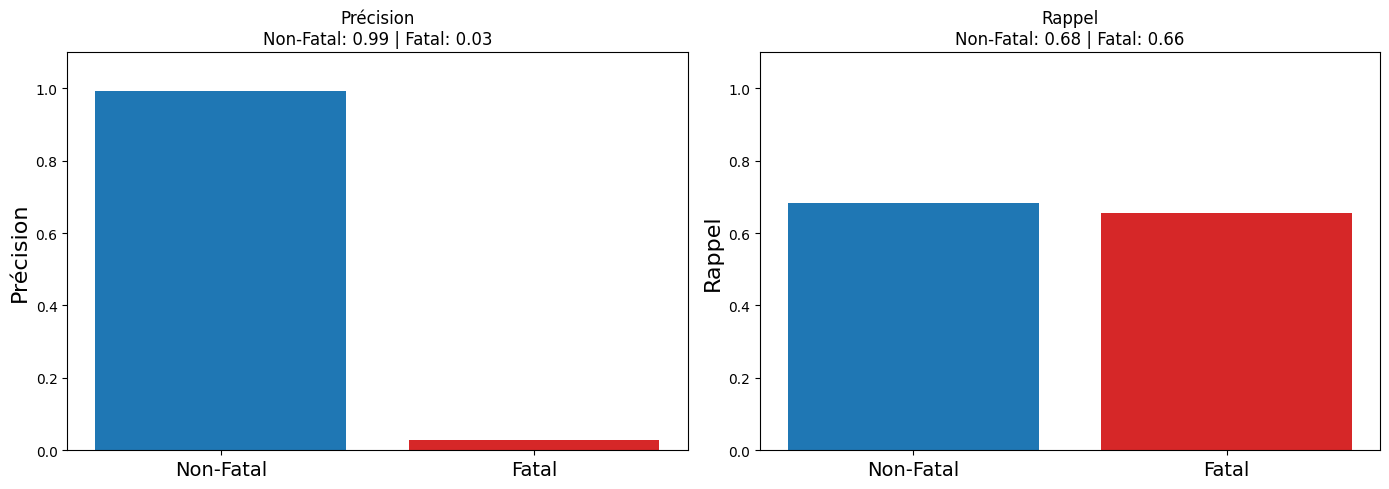

Classe       | F1-Score  
-------------------------
Non-Fatal    | 0.809
Fatal        | 0.052
Assess Test


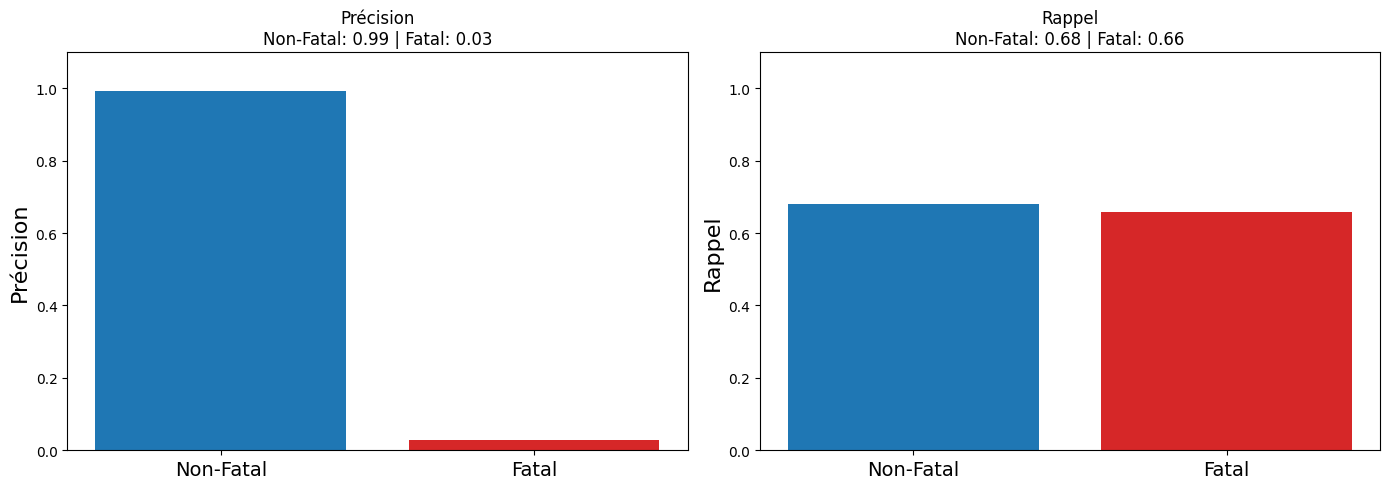

Classe       | F1-Score  
-------------------------
Non-Fatal    | 0.808
Fatal        | 0.052


In [202]:

preds_train_labels = np.where(preds_train == 1, 'Fatal', 'Non-Fatal')
preds_test_labels = np.where(preds_test == 1, 'Fatal', 'Non-Fatal')

y_train_labels = np.where(y_train_binary == 1, 'Fatal', 'Non-Fatal')
y_test_labels = np.where(y_test_binary == 1, 'Fatal', 'Non-Fatal')

print("Assess Train")
get_precisions_recalls_binary(y_train_labels, preds_train_labels)  

print("Assess Test")
get_precisions_recalls_binary(y_test_labels, preds_test_labels)  

Évaluation avec un seuil de 0.5


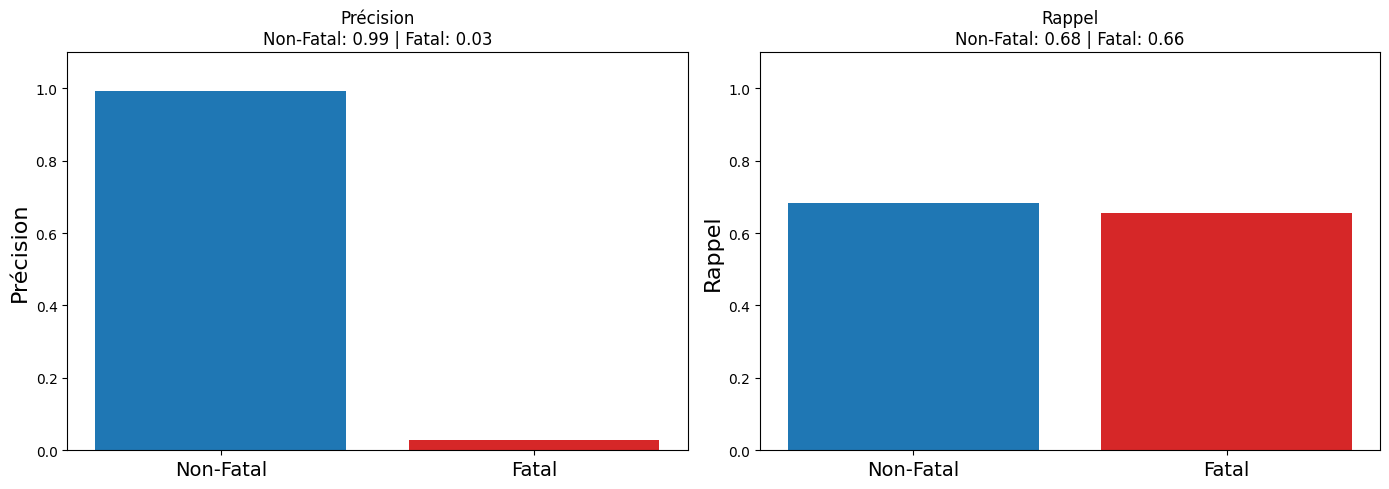

Classe       | F1-Score  
-------------------------
Non-Fatal    | 0.809
Fatal        | 0.052


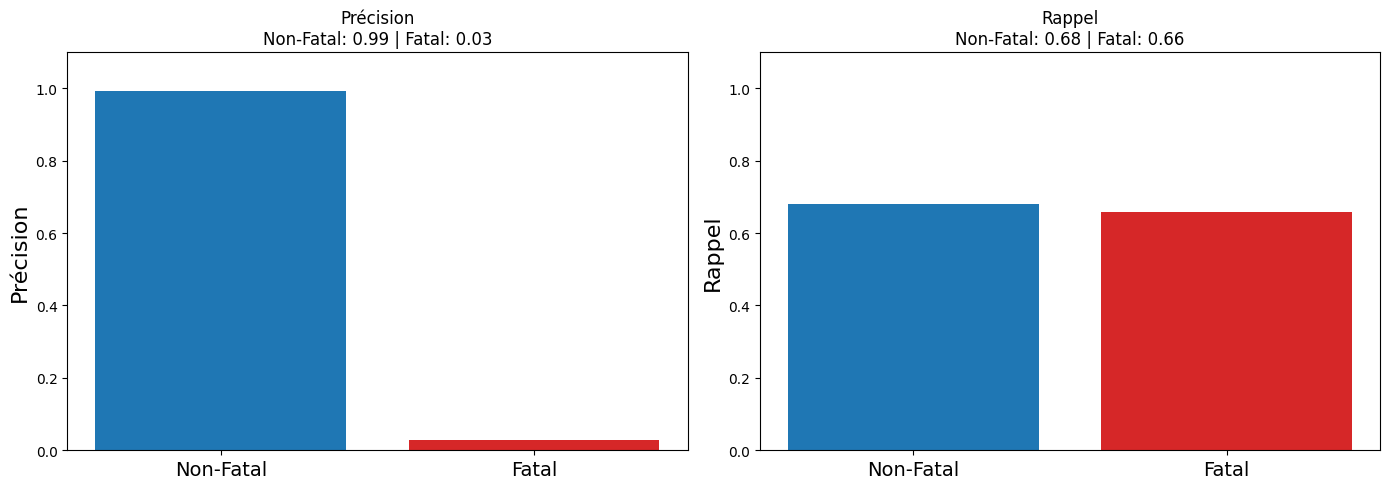

Classe       | F1-Score  
-------------------------
Non-Fatal    | 0.808
Fatal        | 0.052


In [138]:
# 1. Récupérer les probabilités (colonne 1 = probabilité de 'Fatal')
probs_train = xgb_binary.predict_proba(X_train)[:, 1]
probs_test = xgb_binary.predict_proba(X_test)[:, 1]

# 2. Choisir un seuil (Threshold)
# Par défaut c'est 0.5, mais 0.4 ou 0.3 améliore le recall
threshold = 0.5


# 3. Transformer les probabilités en labels selon le seuil
preds_train_custom = np.where(probs_train >= threshold, 'Fatal', 'Non-Fatal')
preds_test_custom = np.where(probs_test >= threshold, 'Fatal', 'Non-Fatal')

# 4. Affichage
print(f"Évaluation avec un seuil de {threshold}")
get_precisions_recalls_binary(y_train_labels, preds_train_custom)
get_precisions_recalls_binary(y_test_labels, preds_test_custom)

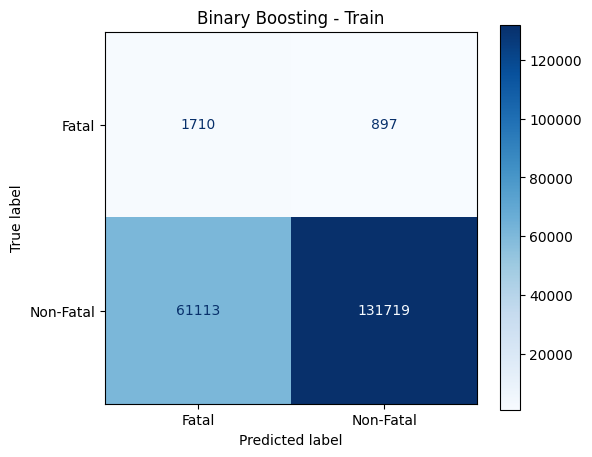

--- Rapport détaillé : Binary Boosting - Train ---
              precision    recall  f1-score   support

       Fatal       0.03      0.66      0.05      2607
   Non-Fatal       0.99      0.68      0.81    192832

    accuracy                           0.68    195439
   macro avg       0.51      0.67      0.43    195439
weighted avg       0.98      0.68      0.80    195439



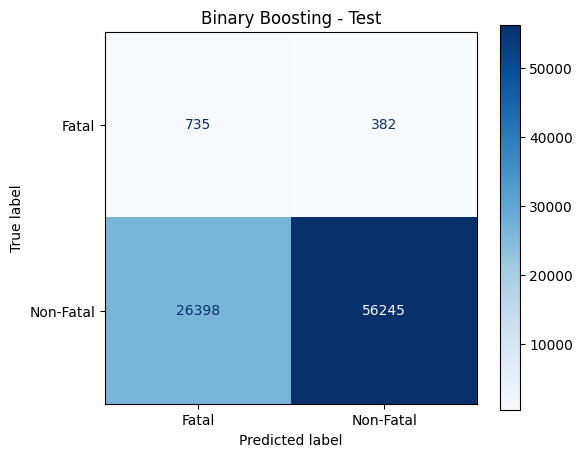

--- Rapport détaillé : Binary Boosting - Test ---
              precision    recall  f1-score   support

       Fatal       0.03      0.66      0.05      1117
   Non-Fatal       0.99      0.68      0.81     82643

    accuracy                           0.68     83760
   macro avg       0.51      0.67      0.43     83760
weighted avg       0.98      0.68      0.80     83760



In [210]:
plot_confusion_binary(y_train_labels, preds_train_custom, 'Binary Boosting - Train')
plot_confusion_binary(y_test_labels, preds_test_custom, 'Binary Boosting - Test')

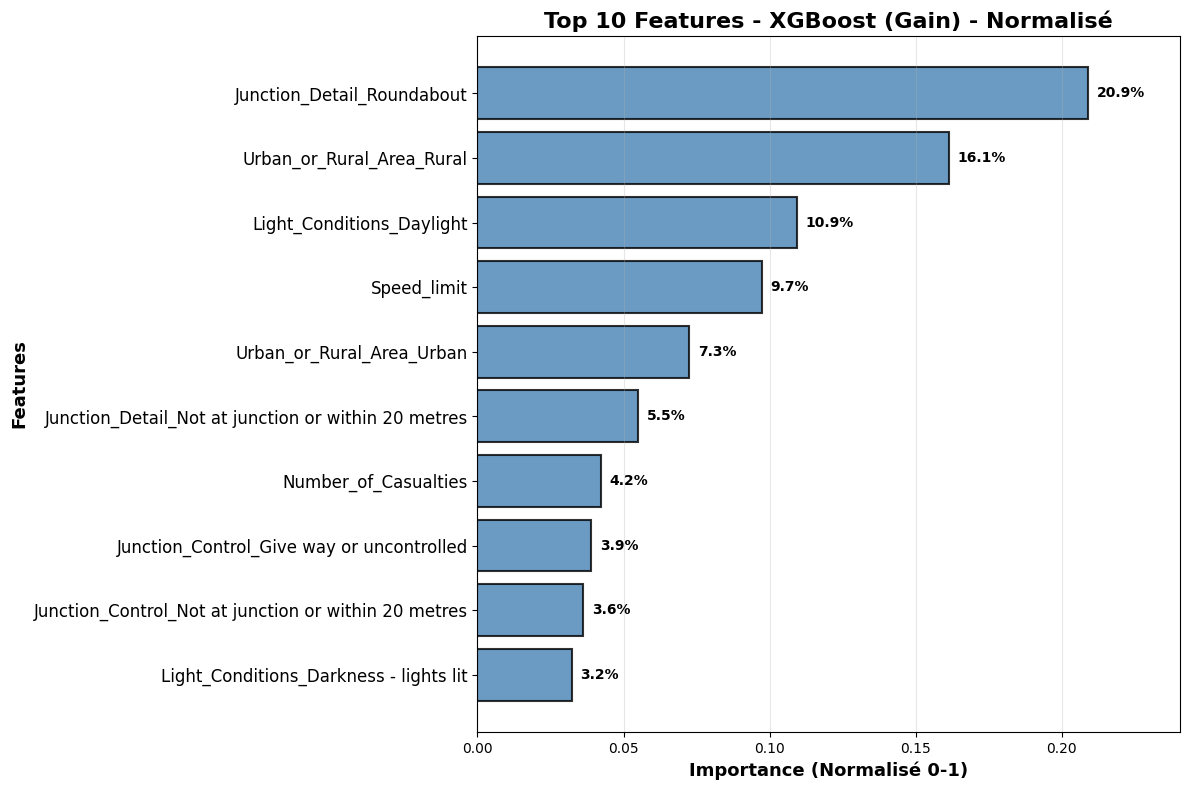

In [144]:
# === EXTRAIRE IMPORTANCE AVEC LES VRAIS NOMS ===
importance_dict = xgb_binary.get_booster().get_score(importance_type='gain')

importances_with_names = {}
for key, value in importance_dict.items():
    feature_idx = int(key[1:])
    importances_with_names[feature_names[feature_idx]] = value

# 🔥 NORMALISER (somme = 1.0)
total_importance = sum(importances_with_names.values())
importances_normalized = {
    feat: imp / total_importance 
    for feat, imp in importances_with_names.items()
}

# Trier et prendre top 10
sorted_features = sorted(importances_normalized.items(), key=lambda x: x[1], reverse=True)
top_n = min(10, len(sorted_features))
top_features = [f[0] for f in sorted_features[:top_n]]
top_importances = [f[1] for f in sorted_features[:top_n]]

# === VISUALISATION (IDENTIQUE À L'IMAGE) ===
plt.figure(figsize=(12, 8))
bars = plt.barh(range(top_n), top_importances[::-1], 
               color='steelblue', alpha=0.8, edgecolor='black', linewidth=1.5)

# Ajouter les valeurs en % sur les barres
for i, (bar, val) in enumerate(zip(bars, top_importances[::-1])):
    width = bar.get_width()
    pct = val * 100
    plt.text(width + 0.003, bar.get_y() + bar.get_height()/2, 
            f'{pct:.1f}%', va='center', fontsize=10, fontweight='bold')

plt.yticks(range(top_n), top_features[::-1], fontsize=12)
plt.xlabel('Importance (Normalisé 0-1)', fontsize=13, fontweight='bold')
plt.ylabel('Features', fontsize=13, fontweight='bold')
plt.title('Top 10 Features - XGBoost (Gain) - Normalisé', fontsize=16, fontweight='bold')
plt.grid(axis='x', alpha=0.3)
plt.xlim([0, max(top_importances) * 1.15])
plt.tight_layout()
plt.show()

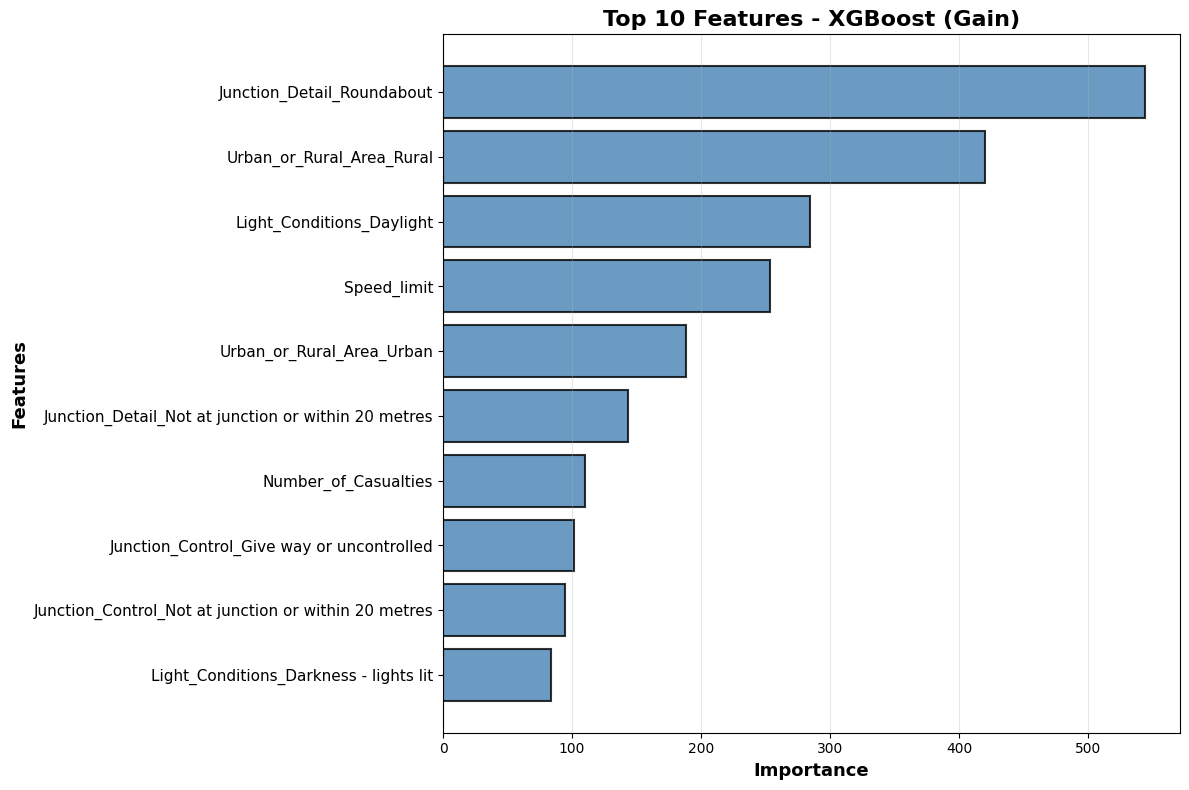

In [148]:
importance_dict = xgb_binary.get_booster().get_score(importance_type='gain')


# Trier par importance
sorted_features = sorted(importances_with_names.items(), key=lambda x: x[1], reverse=True)


# Top 10
top_n = min(10, len(sorted_features))
top_features = [f[0] for f in sorted_features[:top_n]]
top_importances = [f[1] for f in sorted_features[:top_n]]


# === VISUALISATION (MÊME STYLE QUE RANDOM FOREST) ===
plt.figure(figsize=(12, 8))
plt.barh(range(top_n), top_importances[::-1],
         color='steelblue', alpha=0.8, edgecolor='black', linewidth=1.5)
plt.yticks(range(top_n), top_features[::-1], fontsize=11)
plt.xlabel('Importance', fontsize=13, fontweight='bold')
plt.ylabel('Features', fontsize=13, fontweight='bold')
plt.title(f'Top {top_n} Features - XGBoost (Gain)', fontsize=16, fontweight='bold')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

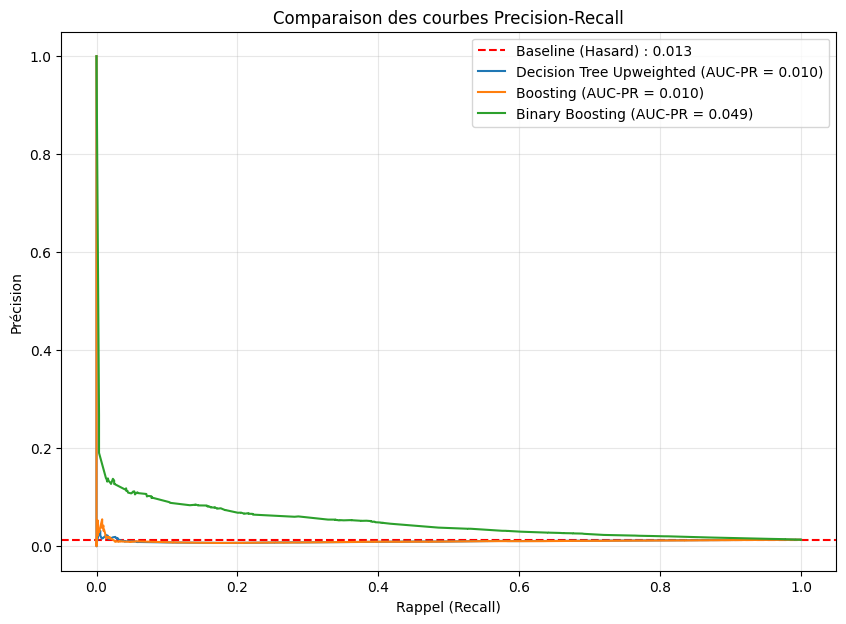

In [157]:
mes_modeles = {
    'Decision Tree Upweighted': clf,
    'Boosting': xgb_clf,
    'Binary Boosting' :xgb_binary,
    #'Balanced Random Forest' : brf,
    #'Random Forest Undersampling': rf,
 }

y_test_numeric = (labels_test == 'Fatal').astype(int)

plot_multiple_pr_curves(mes_modeles, X_test, y_test_numeric)

In [175]:
# 1. On transforme X_test en DataFrame
X_test_df = pd.DataFrame(X_test_clean)

# 2. Appliquer get_dummies
X_test_encoded = pd.get_dummies(X_test_df)

# 3. MISE À JOUR : Le modèle attend maintenant 23 colonnes (puisqu'on en a enlevé une)
# ATTENTION : Vous devez impérativement ré-entraîner votre modèle 'brf' 
# sans cette variable avant de faire ce test !
if hasattr(brf, "feature_names_in_"):
    target_columns = brf.feature_names_in_
else:
    # Si vous avez ré-entraîné le modèle sans 'Casualties', il attend 23 colonnes
    target_columns = [f"col_{i}" for i in range(23)] 

# 4. Alignement final
X_test_new = X_test_encoded.reindex(columns=target_columns, fill_value=0)

# 5. Vérification ultime
if X_test_24.shape[1] == 24:
    print("✅ X_test_24 est prêt avec 24 colonnes.")
else:
    print(f"❌ Erreur : X_test_24 a {X_test_24.shape[1]} colonnes au lieu de 24.")

✅ X_test_24 est prêt avec 24 colonnes.


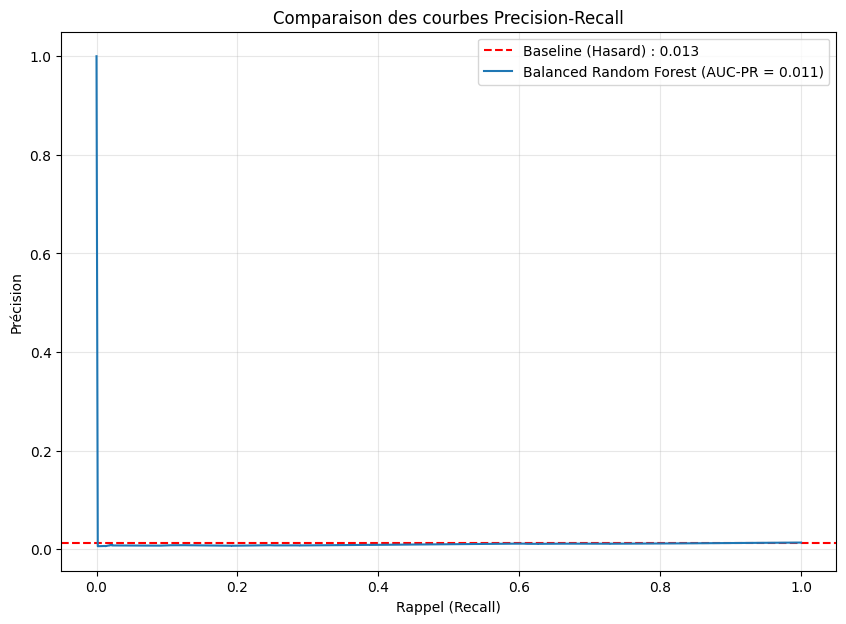

In [177]:
mes_modeles = {
    'Balanced Random Forest' : brf,
    #'Random Forest Undersampling': rf,
 }

y_test_numeric = (labels_test == 'Fatal').astype(int)



plot_multiple_pr_curves(mes_modeles, X_test_clean, y_test_numeric)

# Solution 7 : Isolation Forest

In [37]:
from sklearn.ensemble import IsolationForest


Résultats Isolation Forest (Anomalies = Fatals)


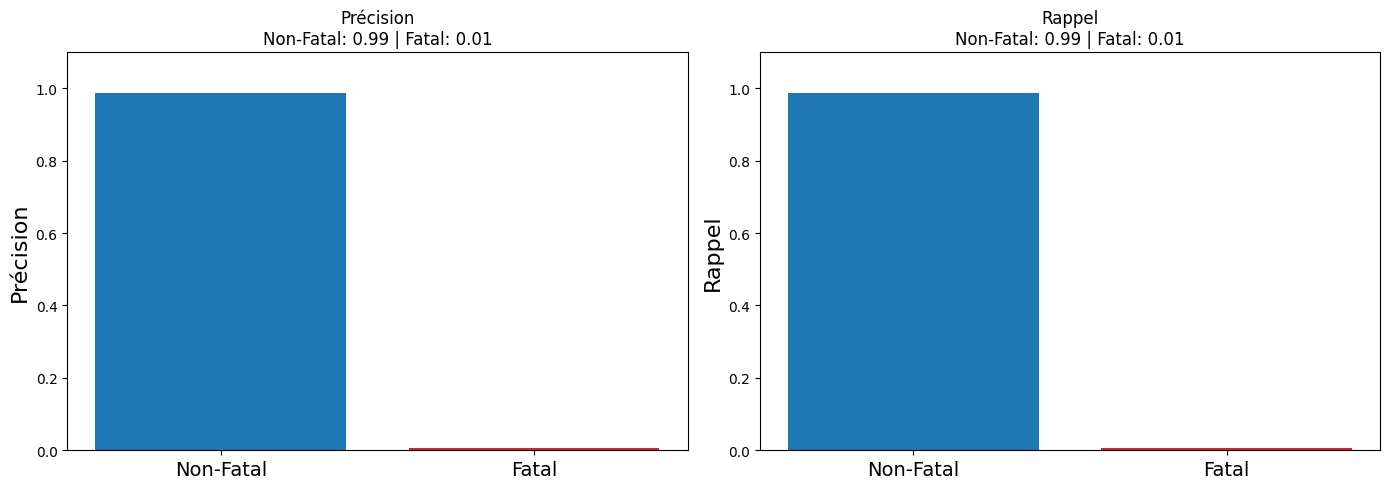

Classe       | F1-Score  
-------------------------
Non-Fatal    | 0.988
Fatal        | 0.007


In [142]:
#1. Préparation du modèle
# contamination : la proportion attendue d'anomalies (vos 'Fatal' représentent ~1.28% soit 0.0128)
iso_forest = IsolationForest(
    n_estimators=200,
    contamination=0.0128, 
    max_samples='auto',
    random_state=42,
    n_jobs=-1
)

# 2. Entraînement (uniquement sur X, sans les labels !)
# On entraîne souvent sur tout le dataset ou juste les cas "Slight" pour apprendre la normalité
iso_forest.fit(X_train)

# 3. Prédiction
# Isolation Forest renvoie -1 pour une anomalie et 1 pour une donnée normale
preds_raw = iso_forest.predict(X_test)

# 4. Conversion pour votre fonction de métriques
# On considère que Anomalie (-1) = Fatal et Normal (1) = Non-Fatal
preds_binary = np.where(preds_raw == -1, 'Fatal', 'Non-Fatal')
actual_binary = np.where(y_test_binary == 1, 'Fatal', 'Non-Fatal')

# Utilisation de votre fonction de diagnostic
print("Résultats Isolation Forest (Anomalies = Fatals)")
get_precisions_recalls_binary(actual_binary, preds_binary)

# Solution 8 : Isolation Forest to create a anomaly score then use a Boosting methode

In [38]:
# 1. Initialisation
# On utilise une contamination légèrement supérieure au taux réel pour être sensible
iso = IsolationForest(contamination=0.02, random_state=42, n_jobs=-1)

# 2. Entraînement et calcul du score sur le TRAIN
# decision_function renvoie un score : plus il est bas/négatif, plus c'est une anomalie
iso.fit(X_train)

# 1. On s'assure que X_train est au bon format avant de copier
if isinstance(X_train, np.ndarray):
    # Si c'est un array, on le convertit en DataFrame
    # Note: On perd les noms de colonnes originaux s'ils n'ont pas été sauvegardés
    X_train_enriched = pd.DataFrame(X_train)
else:
    X_train_enriched = X_train.copy()

X_train_enriched['anomaly_score'] = iso.decision_function(X_train)


# 3. Même chose pour le test
if isinstance(X_test, np.ndarray):
    X_test_enriched = pd.DataFrame(X_test)
else:
    X_test_enriched = X_test.copy()
# 3. Calcul du score sur le TEST (on réutilise le modèle du train)

X_test_enriched['anomaly_score'] = iso.decision_function(X_test)

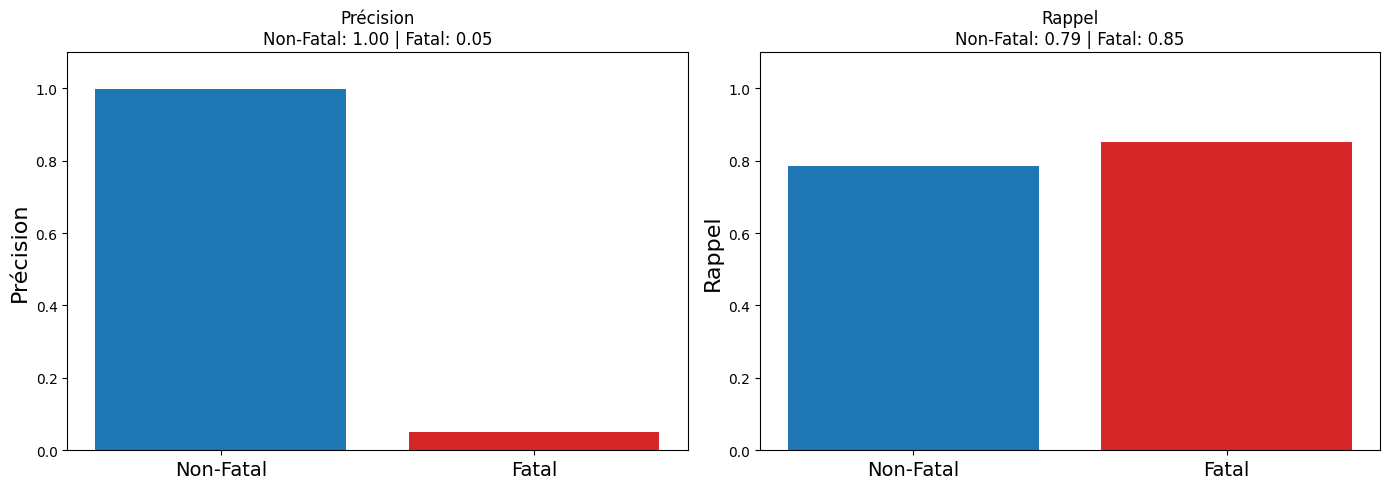

Classe       | F1-Score  
-------------------------
Non-Fatal    | 0.880
Fatal        | 0.093


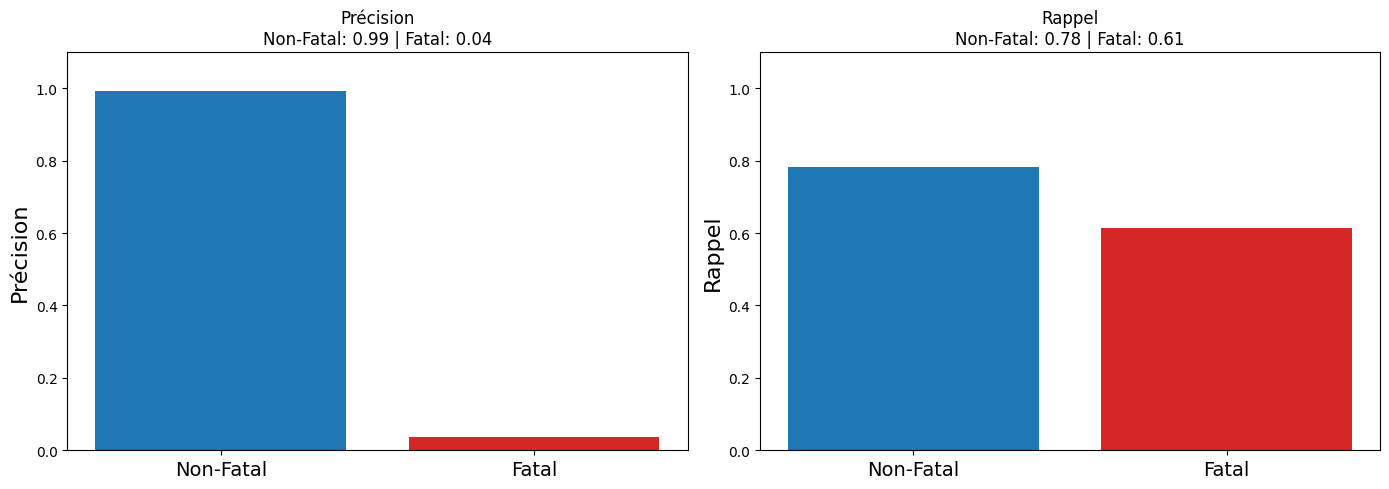

Classe       | F1-Score  
-------------------------
Non-Fatal    | 0.876
Fatal        | 0.067


In [40]:
# On garde vos meilleurs paramètres trouvés précédemment
xgb_hybrid = xgb.XGBClassifier(
    max_depth=8,                # Légèrement réduit pour compenser la nouvelle variable
    min_child_weight=10,        # Votre réglage optimal
    learning_rate=0.1,
    n_estimators=500,
    scale_pos_weight=ratio,     # Toujours indispensable !
    reg_lambda=10,              # Augmenté pour la stabilité
    objective='binary:logistic',
    eval_metric=['aucpr'],
    random_state=42,
    early_stopping_rounds=30,
)

# Entraînement avec la nouvelle variable 'anomaly_score'
xgb_hybrid.fit(
    X_train_enriched, y_train_binary,
    eval_set=[(X_test_enriched, y_test_binary)],
    
    verbose=False
)

preds_train = xgb_hybrid.predict(X_train_enriched)
get_precisions_recalls_binary(y_train_labels, np.where(preds_train==1, 'Fatal', 'Non-Fatal'))

# Prédiction et évaluation
preds_hybrid = xgb_hybrid.predict(X_test_enriched)
get_precisions_recalls_binary(y_test_labels, np.where(preds_hybrid==1, 'Fatal', 'Non-Fatal'))

Évaluation avec un seuil de 0.4


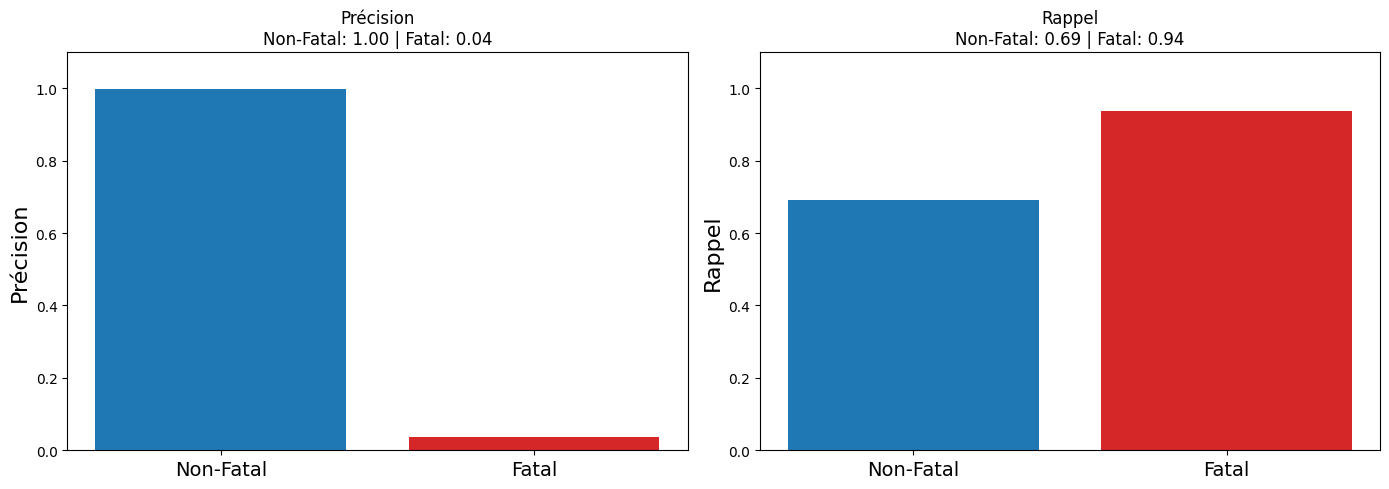

Classe       | F1-Score  
-------------------------
Non-Fatal    | 0.817
Fatal        | 0.073


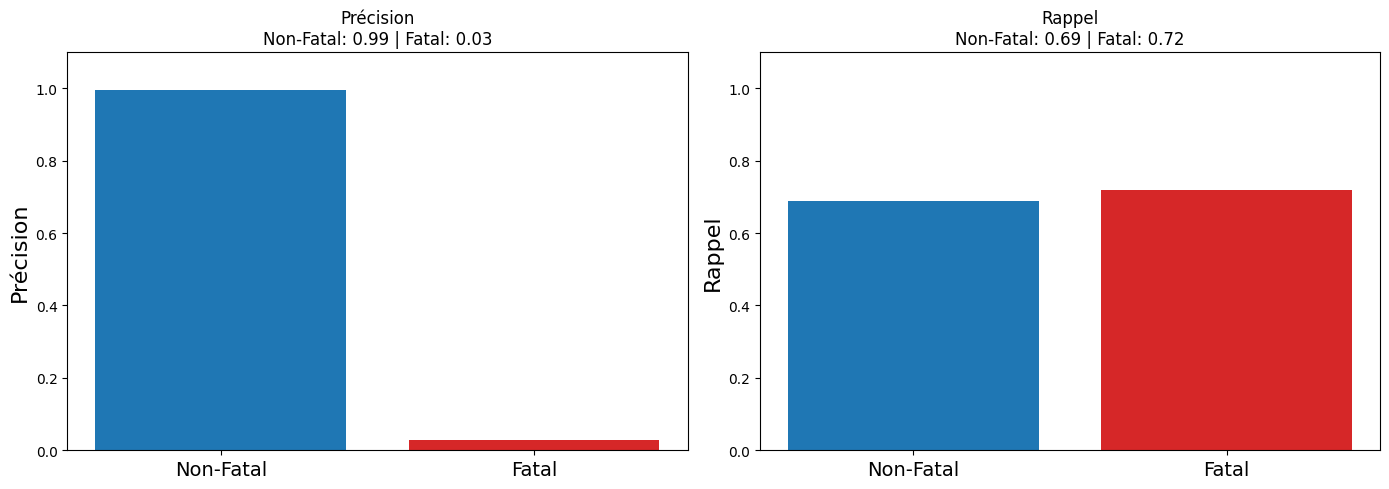

Classe       | F1-Score  
-------------------------
Non-Fatal    | 0.813
Fatal        | 0.056


In [159]:
# 1. Récupérer les probabilités (colonne 1 = probabilité de 'Fatal')
probs_train = xgb_hybrid.predict_proba(X_train_enriched)[:, 1]
probs_test = xgb_hybrid.predict_proba(X_test_enriched)[:, 1]

# 2. Choisir un seuil (Threshold)
# Par défaut c'est 0.5, mais essaie 0.7 ou 0.8 pour monter la précision
threshold = 0.4


# 3. Transformer les probabilités en labels selon le seuil
preds_train_custom = np.where(probs_train >= threshold, 'Fatal', 'Non-Fatal')
preds_test_custom = np.where(probs_test >= threshold, 'Fatal', 'Non-Fatal')

# 4. Affichage
print(f"Évaluation avec un seuil de {threshold}")
get_precisions_recalls_binary(y_train_labels, preds_train_custom)
get_precisions_recalls_binary(y_test_labels, preds_test_custom)